# Рекомендательные системы

* задачи рекомендательных систем 
* особенности данных
* метрики и модели
* реализация некоторых рекомендательных систем

Исходный *[Репозиторий](https://github.com/monkey0head/recsys_sem)*

*Автор:* 
@monkey_head

# Содержание
- Датасет
    - типы feedback
    - что можно рекомендовать?
- Как влияет на решение задачи рекомендаций предметная область и поведение пользователей?
- EDA
- 0 Фильтрация данных
- 1 Разбиение данных
- 2 Простейшая рекомендательная система
- 3 Класс-рекомендатель
- 4 Оценка качества рекомендаций: Метрики качества и разнообразия
- 5 Item-to-item модель на примере ассоциативных правил
- Модели для задачи рекомендаций top-k объектов для пользователя
    - 6 SVD
    - 7 LightFM
- 8 Двухуровневая модель (SVD + CatBoost)
- Нейросетевые модели
    - 9 MiltVAE

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
! pip install -r requirements.txt
# ! pip install -r drive/MyDrive/"PATH TO REQ"/requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from typing import Optional

import abc
import numpy as np
import math
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [4]:
#data_path = 'drive/MyDrive/YOUR PATH TO DATA HERE/data/'
data_path = 'data/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [5]:
SEED = 123
K=10

# Датасет

Будем использовать датасет [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащий данные об истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [6]:
df = pd.read_csv(data_path+log_name, sep=',')

In [7]:
assert df.shape[0] == 1533078

In [8]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

CPU times: user 398 ms, sys: 0 ns, total: 398 ms
Wall time: 397 ms


In [9]:
u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

In [10]:
u_features.head()

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0
2,3,65_inf,0.0
3,4,18_24,0.0
4,5,35_44,0.0


In [11]:
i_features.head()

,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [12]:
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1437,97128,245669,1,NaN,2018-01-01
1436,47427,46915,54,NaN,2018-01-01
1435,95067,165632,6,NaN,2018-01-01
1434,110053,141651,86,NaN,2018-01-01


Конвертируем id пользователей и item-ов в подряд идущие номера с помощью [sklearn.preprocessing.LabelEncoder]([https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html])

In [13]:
%%time
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(pd.concat([df['user_id'], u_features['user_id']]).values)
item_encoder.fit(pd.concat([df['item_id'], i_features['item_id']]).values)

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 208 ms


LabelEncoder()

In [14]:
user_encoder.classes_

array([     0,      1,      2, ..., 159610, 159611, 159612])

In [15]:
%%time
df['user_id'] = user_encoder.transform(df['user_id'])
df['item_id'] = item_encoder.transform(df['item_id'])

CPU times: user 595 ms, sys: 0 ns, total: 595 ms
Wall time: 594 ms


In [16]:
%%time
u_features['user_id'] = user_encoder.transform(u_features['user_id'])
u_features.set_index('user_id', inplace=True)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.7 ms


### Данные

In [17]:
%%time
i_features['item_id'] = item_encoder.fit_transform(i_features['item_id'])
i_features.set_index('item_id', inplace=True)

CPU times: user 9.17 ms, sys: 0 ns, total: 9.17 ms
Wall time: 7.23 ms


In [18]:
def get_df_info(df, user_id='user_id', item_id='item_id'):
    print(f'Размер данных = {df.shape[0]},\nколичество пользователей = {df[user_id].nunique()},\nколичество объектов = {df[item_id].nunique()}')

In [19]:
get_df_info(df)

Размер данных = 1532998,
количество пользователей = 151600,
количество объектов = 59599


Посчитаем количество строк, у которых есть рейтинг, и количество данных о прогрессе чтения

In [20]:
has_rating_count =  df['rating'].notna().sum()
assert has_rating_count == 285337
has_progress_count = df['progress'].notna().sum()
assert has_progress_count == 1532998

In [21]:
print(f"Количество рейтингов = {has_rating_count}\nколичество данных о прогрессе чтения = {has_progress_count}")


Количество рейтингов = 285337
количество данных о прогрессе чтения = 1532998


## Особенности данных в задаче рекомендаций
- всегда есть id пользователей/сессий и объектов
- часто есть timestamp (знаем об изменениях предпочтений пользователей во времени)
- есть оценка релевантности объектов для пользователей

## Типы feedback
В нашем датасете есть progress - процент прочтения книги и rating - оценка, которую пользователь поставил. 
Это отличная иллюстрация для implicit (явный) и explicit (неявный) feedback. 

**Explicit**

Если пользователь поставил оценку, мы можем быть сильно уверены в том, насколько ему нравится книга
- мало, но четко отражает предпочтения пользователя
- можно учить модели регрессии и ранжирования
- смещен в сторону "оценивает лучшая версия меня" (хоть мы и не говорим сегодня о вопросах психологии/этики)
- может быть двумодальное распределение (хочу похвалить или хочу поругать)

**Implicit**

Факт прочтения какой-то доли контента — тоже важный сигнал, и этой информации гораздо больше
- много
- разнородный
- часто не содержит негативного опыта/его надо извлекать на основе правил
- показывал реальные предпочтения пользователей

## Задачи

* предсказать для пользователя top-k релевантных объектов
* оценить релевантность выбранных пар пользователь-объект / переранжировать объекты для пользователя (для новых объектов)
* найти похожие объекты/похожих пользователей
* рекомендовать к сессии/корзине/товару

# Как влияет на решение задачи рекомендаций тип объектов и поведение пользователей?
Различных моделей для решения задачи рекомендаций — много, идеального способа выбрать нужную модель нет, но можно попробовать хотя бы определить тип.
Поговорим о том, насколько разной может быть задача рекомендаций с точки зрения скорости изменения интересов пользователей и скорости устаревания объектов.

In [22]:
%%html
<iframe src="https://drive.google.com/file/d/10XsrZ_c5wvTTVv3no835aLRNs_fWvFdD/preview" width="640" height="480" allow="autoplay"></iframe>

Ось Х - скорость изменения интересов пользователя

Ось Y - скорость изменения актуальности объектов

**Задание 1 (0.5 балла)** 
Приведите примеры, когда:
- интересы пользователя изменяются быстро, актуальность объектов изменяется быстро
- интересы пользователя изменяются быстро, актуальность объектов изменяется медленно
- интересы пользователя изменяются медленно, актуальность объектов изменяется быстро
- интересы пользователя изменяются медленно, актуальность объектов изменяется медленно

#MY ANSWER HERE:
- *Новости - свежие статьи появляются быстро, интерес меняется быстро*
- *Интернет-магазин - новые товары появляются медленно, заинтересованность пользователя меняется быстро*
- *Онлайн-кинотеатр - новые фильмы выходят часто, предпочтения меняются медленно*
- *Книжный магазин -- новые книги выходят редко, куча старых книг, предпочтения меняются медленно*


Кроме скорости устаревания можно придумать еще несколько факторов, влияющих на то, какую рекомендательную систему строить:

- сколько item-ов есть и насколько они похожи?
- item-ы потребляются один раз или с какой-то частотой?
- важна ли последовательность потребления (второй сезон сериала после первого)?
- авторизуются ли пользователи при посещении сайта?
- нужно ли реагировать онлайн или достаточно посчитать рекомендации один раз в сутки?

К чему этот график выше? Чтобы понять, какие модели точно не подойдут, а какие стоит рассмотреть внимательнее.

Глобально по типу используемых данных можно выделить:
- классические модели, основанные на логе взаимодействия (коллаборативная фильтрация)
- Content-based (используют сходство признаков объектов/пользователей)
- Hybrid/Assembly (сложные/использующие как лог, так и признаки, включающие несколько моделей)


Плюс на графике отмечены еще session-based (используют данные сессий отдельных пользовательских сессий, а не всю историю)

ps: это не классификация всех возможных рекомендательных моделей, а просто выделение некоторых групп для понимания, почему не любую задачу можно решить ALS-ом

In [23]:
%%html
<iframe src="https://drive.google.com/file/d/1-dRZaq3OOY1w-M8bHGF3ldCOYZ-uWVId/preview" width="640" height="480" allow="autoplay"></iframe>

# EDA

## Распределение рейтинга и доли прочтения

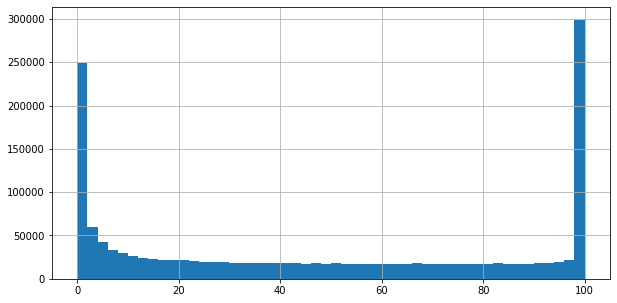

In [24]:
df['progress'].hist(bins=50, figsize=(10, 5));

Либо бросают быстро, либо дочитывают до конца

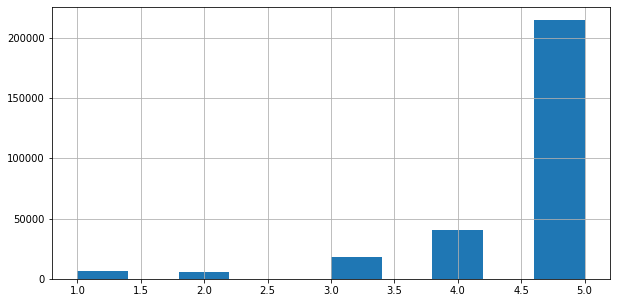

In [25]:
df['rating'].hist(bins=10, figsize=(10, 5));

 Оценивают понравившееся 

In [26]:
df['rating'].value_counts()

5.0    214703
4.0     40382
3.0     18273
1.0      6115
2.0      5864
Name: rating, dtype: int64

## Распределение числа прочтений у пользователя / книги

In [27]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

count    151600.000000
mean         10.112124
std          20.922963
min           1.000000
5%            3.000000
25%           5.000000
50%           7.000000
75%          10.000000
95%          20.000000
max        2091.000000
Name: progress, dtype: float64


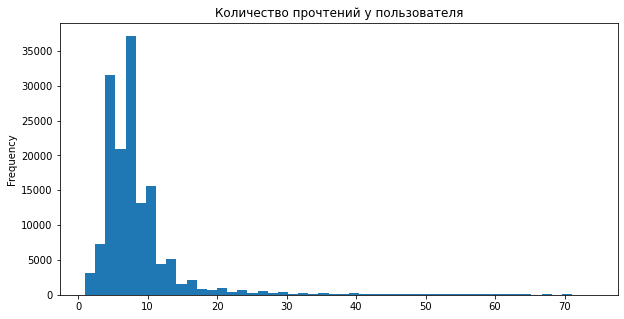

In [28]:
user_count = group_by_and_plot(df, group_by_name='user_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у пользователя')

count    59599.000000
mean        25.721875
std         60.665733
min          2.000000
5%           9.000000
25%         13.000000
50%         16.000000
75%         21.000000
95%         65.000000
max       6575.000000
Name: progress, dtype: float64


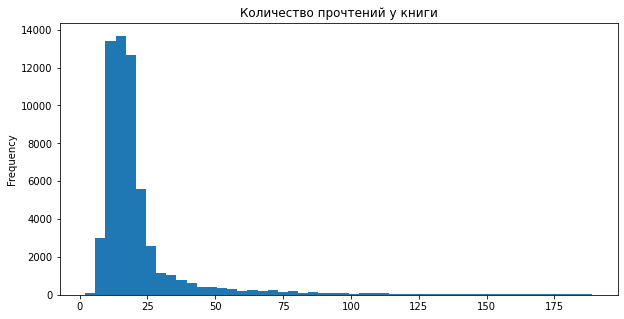

In [29]:
item_count = group_by_and_plot(df, group_by_name='item_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у книги')

Данные довольно плотные, у 95% пользователей более трех взаимодействий, у 95% книг более 9 прочтений

count    101885.000000
mean          2.800579
std          10.026988
min           1.000000
5%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
95%           5.000000
max         691.000000
Name: rating, dtype: float64


user_id
0         2
1         3
2         1
3         1
6         1
         ..
158804    1
158805    1
158806    1
158809    1
158810    2
Name: rating, Length: 101885, dtype: int64

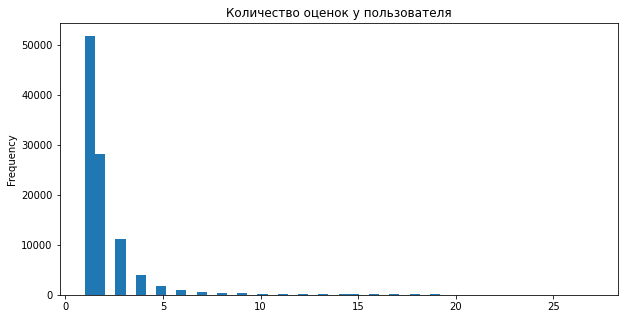

In [30]:
group_by_and_plot(df[~df['rating'].isna()], group_by_name='user_id', rating_col_name='rating', quantile=0.99, title='Количество оценок у пользователя')

Оценок гораздо меньше. Часто мы не хотим что-то рекомендовать человеку на основании одной оценки или строить матричные разложения/учить сетки на супер-разреженных данных, и поэтому используем implicit feedback (в нашем случае - историю чтения книг)

<a id='filter'></a>
# 0 Фильтрация данных

Будем использовать историю чтения книг, а не оценки, так как этих данных больше и они могут лучше характеризовать актуальные предпочтения пользователей. 

Что такое релевантная книга по доле прочитанного? Прочитанная на 100%? А если на 60%?
Самый простой способ — отталкиваться от бизнес-требований и бизнес-метрик. У нас нет бизнес-задачи, поэтому придумаем сами!


### Оставим взаимодействия с progress > 50

In [31]:
filtered_df = df[df['progress'] > 50]

In [32]:
get_df_info(filtered_df)

Размер данных = 712368,
количество пользователей = 143465,
количество объектов = 59560


### Удалим объекты с менее 3 взаимодействиями и пользователей с менее 5 взаимодействиями

Облегчим себе жизнь и уменьшим размеры датасета. В индустрии и академии тоже так делают)

1) оставьте в filtered_df книги с 3 и более взаимодействиями, 

2) после этого оставьте в filtered_df пользователей с 5 и более взаимодействиями

In [33]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 2]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [34]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)]

In [35]:
get_df_info(filtered_df)

Размер данных = 446121,
количество пользователей = 37004,
количество объектов = 56752


In [36]:
assert filtered_df.shape[0] == 446121
assert filtered_df['user_id'].nunique() == 37004

# 1 Разбиение данных

Как построить локальную валидацию? 
Опять же, исходя из реальной задачи. В реальности у нас есть срез истории взаимодействия в прошлом и мы хотим предсказать предпочтения пользователей в будущем.
В статьях разных лет используются:
- случайное разбиение
- случайное внутри истории пользователя (k item-ов каждого пользователя в test)
- leave-one-out / leave-k-out  по времени
- time-based (например, взаимодействия в течение будущих 7 дней)

Почему плохо разбивать без учета timestamp? 

Реализуем time-based разбиение, оставим в test только активных пользователей и возьмем первые K взаимодействий.

In [37]:
%%html
<iframe src="https://drive.google.com/file/d/1L7dgH9lMYHBpxPASPJEUjm8U3_f9VrdQ/preview" width="640" height="480" allow="autoplay"></iframe>

Вообще лучше не ограничиваться одним сплитом, а делать blocking time series cross-validation (например, разбивать данные по месяцам)


![blocking cv](https://hub.packtpub.com/wp-content/uploads/2019/05/Blocking-Time-Series-Split.png)

## Разобьем датасет на train и test по времени, взяв 20% наиболее свежих взаимодействий в test

In [38]:
train_by_date = filtered_df[filtered_df['start_date'] <= filtered_df['start_date'].quantile(0.8)]
test_by_date = filtered_df[filtered_df['start_date'] > filtered_df['start_date'].quantile(0.8)]

In [39]:
assert train_by_date.shape[0] == 357518
assert test_by_date.shape[0] == 88603

## Оставим в test только пользователей, у которых в test 5 и более взаимодействий и возьмем первые 5 из них

In [40]:
counts_in_test = test_by_date.groupby('user_id')['item_id'].count()
test_by_date = test_by_date[test_by_date['user_id'].isin(counts_in_test[counts_in_test > 4].index)]
test_by_date['rank'] = test_by_date.groupby('user_id')['start_date'].rank(method="first", ascending=True)
test_by_date = test_by_date[test_by_date['rank'] <= 5].drop(columns=['rank'])

# удалим холодных пользователей
test_by_date = test_by_date[test_by_date['user_id'].isin(train_by_date['user_id'].unique())]
test_by_date_users = test_by_date['user_id'].drop_duplicates()

In [41]:
assert test_by_date.shape[0] == 15230

In [42]:
get_df_info(train_by_date)

Размер данных = 357518,
количество пользователей = 36823,
количество объектов = 55098


In [43]:
get_df_info(test_by_date)

Размер данных = 15230,
количество пользователей = 3046,
количество объектов = 7825


# 2 Первая модель — рекомендуем популярное

Самый простой рекомендатель — модель, которая будет рекомендовать популярные книги (книги, которые чаще всего читали). Построим такую модель.

## 2.1 Задание (0.5 балла): посчитайте популярность (отношение числа пользователей, читавших книгу, к общему числу пользователей) книг по train-датасету и выведите топ-10 самых популярных книг с названиями. 

In [44]:
popularity = pd.Series(
    train_by_date.groupby('item_id')['user_id'].count() / train_by_date['user_id'].unique().shape[0], 
    name='popularity'
).sort_values(ascending=False)

In [45]:
assert math.isclose(popularity[16683], 0.016050, abs_tol=1e-6)

In [46]:
pd.DataFrame(popularity).merge(i_features, on='item_id').head(10)

,popularity,title,genres,authors,year
item_id,,,,,
16683,0.016050,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015
59157,0.013633,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
49181,0.012791,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
22649,0.012709,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
20939,0.010673,После ссоры,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
50905,0.010591,Чистовик,Научная фантастика,Сергей Лукьяненко,2007
46704,0.010401,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
29612,0.008663,Пятьдесят оттенков серого,"Эротические романы,Зарубежные любовные романы",Э. Л. Джеймс,2012
18388,0.008500,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013


### Первая книга — Зулейха открывает глаза? Значит все ок. Поздравляю, вы написали первую рекомендательную систему!

Что не так?
- Мы все-таки хотим предсказывать для пользователя, и хотим отфильтровать уже прочитанные им книги
- Хотим получить predict для пользователей в виде датафрейма с колонками `user_id - item_id - relevance`
- Хотим уметь получать нужное количество рекомендаций для каждого пользователя
- Хотим в конце концов делать fit - predict!

Поэтому сделаем базовый класс для рекомендателя, и будем наследовать от него наши алгоритмы.

# 3 Класс ParentModel

## 3.1 Задание (0.25 балла): посмотрите на код ниже и ответьте на вопросы:
- как работают leave_top_k и _filter_seen?
- что делает predict?

#MY ANSWER HERE
1. `leave_top_k` - если строк с одним и тем же `user_id` больше `k`, выбрасывает строки с наименьшим `relevance`
    - создается колонка `rank`. Чем больше `relevance`, тем меньше `rank`
    - возвращает строки с `rank` <= `k`
2. `filter_seen_items` - возвращает те строки из `pred`, которых нет в `log`
    - `log_filtered` содержит те строки из `log`, `user_id` которых существует в `pred`
    - к `pred` примермерживается `log_filtered` по `['user_id', 'item_id']`
    - возвращает строки с такими парами `['user_id', 'item_id']`, которые были в изначальном `pred` кроме тех, что в `log_filtered`
3. `predict` - вызывает абстрактный `_predict`, результат фильтрует, если надо, затем возвращает `leave_top_k`

In [47]:
from copy import deepcopy

In [48]:
def leave_top_k(pred: pd.DataFrame, 
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred


def filter_seen_items(log: pd.DataFrame, 
                 pred: pd.DataFrame) -> pd.DataFrame:
    """
    filter pairs `user-item` present in log out of pred
    """
    log_filtered = log[log['user_id'].isin(pred['user_id'].unique())]
    pred = pred.merge(log_filtered[['user_id', 'item_id']].drop_duplicates(), 
                                on=['user_id', 'item_id'], 
                                how='outer', 
                                indicator = True)
    return pred[pred['_merge'] == 'left_only'].drop(columns=['_merge'])


class ParentModel:
    @abc.abstractmethod
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        """
        fit recommender
        
        Parameters
        ----------
        log : pandas dataframe with columns [user_id, item_id, timestamp, relevance]
        user_features : pandas dataframe with column `user_id` and features columns
        item_features : pandas dataframe with column `item_id` and features columns

        Returns
        -------
        
        """
    
    
    def predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen: bool = True) -> pd.DataFrame:
        """
        predict with fitted model, filter seen and crop to top-k for each user
        
        Parameters
        ----------
        log: pandas dataframe with columns [user_id, item_id, timestamp, relevance]
            used to filter seen and to make predictions by some models
        users: user ids to recommend for
        k: number of recommendations for each user
        user_features: pandas dataframe with column `user_id` and features columns
        item_features: pandas dataframe with column `item_id` and features columns
        filter_seen: if True, items present in user history are filtered from predictions

        Returns
        -------
        pandas dataframe with columns [user_id, item_id, relevance] 
            top-k recommended items for each user from `users`.
        """
        
        # overhead
        max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0
        
        pred = self._predict(
            log=log,
            users=users, 
            k=max_items_in_train+k,
            user_features=user_features, 
            item_features=item_features,
            filter_seen=filter_seen)
        if filter_seen:
            pred = filter_seen_items(log, pred)
            
        return leave_top_k(pred, k)
    
    
    @abc.abstractmethod    
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        """
        predict with fitted model
        """

## 3.2 Задание (0.25 балла): Модель для рекомендаций популярного 
- допишите fit. Сохраните популярность объектов в атрибуте items_popularity
- допишите _predict (фильтрацию просмотренных за вас потом сделает predict). 

relevance = популярность книги: отношение числа пользователей, читавших книгу, к общему числу пользователей

In [49]:
class PopularModel(ParentModel):
    items_popularity: pd.DataFrame
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'PopularModel':
        # ======= YOUR CODE HERE ==========
        self.items_popularity = pd.Series(
            train_by_date.groupby('item_id')['user_id'].count() / train_by_date['user_id'].unique().shape[0], 
            name='relevance'
        ).sort_values(ascending=False)
        # =================================
        return self
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:

        # ======= YOUR CODE HERE ==========
        return pd.DataFrame((
            {'user_id': user_id, 'item_id': item_id, 'relevance': relevance} 
            for user_id in test_by_date_users
            for item_id, relevance in rec.items_popularity[:k].items()
        ))
        # return pd.DataFrame(self.items_popularity).merge(users, how='outer')
        # =================================


In [50]:
%%time
rec = PopularModel()
rec.fit(train_by_date)

CPU times: user 22.4 ms, sys: 240 µs, total: 22.6 ms
Wall time: 22 ms


In [51]:
%%time 
pred = rec.predict(log=train_by_date, users=test_by_date_users, k=K, filter_seen=True)

CPU times: user 4.29 s, sys: 407 ms, total: 4.7 s
Wall time: 4.7 s


In [52]:
pred.head(11)

,user_id,item_id,relevance
0,112167,16683,0.016050
1,112167,59157,0.013633
2,112167,49181,0.012791
3,112167,22649,0.012709
4,112167,20939,0.010673
5,112167,50905,0.010591
6,112167,46704,0.010401
7,112167,29612,0.008663
8,112167,18388,0.008500
9,112167,50385,0.008337


In [53]:
assert pred.shape[0] == test_by_date_users.shape[0] * K
assert (pred.groupby('user_id')['item_id'].count() == K).all()
assert pred['item_id'].nunique() > K

## **Задание 3.3 (0.25 балла)** Сделайте выводы о полученных рекомендациях. Учитывают ли рекомендации данные пользователя?


#MY ANSWER HERE  
*Каждому пользователю рекомендуется топ-k популярных книг. Это, наверное, лучше, чем просто рекомендовать случайные. Рекомендации данные пользователя не учитывают.*

## Улучшение рекомендаций популярного
Мы рекомендовали популярное, это максимально простая модель, у которой могут быть простые улучшения. Например, можно подобрать период, за который берутся данные или учитывать более "свежие" взаимодействия с большим весом.

# 4 Метрики

Как понять, что понравится пользователю? Для максимальной достоверности — порекомендовать и посмотреть на его поведение (кликнет/купит/посмотрит ли рекомендованные айтемы).

Но жизнь устроена по-другому!

A/B-тестирование - честно, но:
- дорого
- сложно
- рискованно
- не походит для прототипирования.

A/B на синтетических данных:
- не научились пока качественно моделировать поведение пользователей

Поэтому в первую очередь для оценки качества применяются offline эксперименты, и измеряют offline-метрики.

Метрики качества:
- регрессионные метрики (RMSE, MAE)
- метрики классификации и ранжирования (precision, recall, Mean Average Precision, NDCG)

Метрики разнообразия:
- coverage, surprisal, diversity, ets

In [54]:
! pip install rs_metrics

Defaulting to user installation because normal site-packages is not writeable


In [55]:
from rs_metrics import mapr

## Реализуем несколько метрик, специфичных для рекомендательных систем

Метрики в рекомендациях часто рассчитываются для каждого пользователя для top-к рекомендаций, в ground truth при этом учитываются все релевантные объекты, а не только top-К. Затем метрики усредняются по пользователям.

## HitRate
 = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе
 
## 4.1 Посмотрите на подсчет hit rate для одного пользователя

In [56]:
def user_hr(row):
    """
    Calculate HitRate value for pandas row with user_id, a list of ground truth items in ``gt_items``
    and list or recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [57]:
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]})) == 1
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': [4, 5, 2, 6]})) == 0
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]})) == 0

## 4.2 Посмотрите на функцию-обертку, которая будет приводить данные в нужный формат, вызывать нужную метрику и считать среднее
Перед реализацией подсчета метрики для всех пользователей подумайте:

1) Как должны учитываться в метриках пользователи, для которых мы что-то предсказали, но в test они отсутствуют (ничего не купили / не начали читать / вообще не пользовались сервисом)?

2) Как должны учитываться пользователи, которые есть в test, но мы не смогли получить для них предсказания (например, модель не предсказывает для холодных)

3) Как повлияют на значение метрик пользователи с очень длинной и очень короткой историей в test? Какой самый простой способ бороться с влиянием этих пользователей на значения метрик?

In [58]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').
    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """    
    pred_cropped = leave_top_k(pred, k)
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [59]:
metric_all, _ = metric_wrap(pred, test_by_date, k=K, metric_by_user=user_hr)
assert math.isclose(metric_all, 0.022324, abs_tol=1e-6)

In [60]:
metric_part, _ = metric_wrap(pred[:1000], test_by_date, k=K, metric_by_user=user_hr)
assert metric_part < metric_all

## MRR@K 
- обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. Если релевантных рекомендаций нет, равен нулю.



## 4.3 Задание (0.25): реализуйте подсчет mrr для одного пользователя 

In [61]:
def user_mrr(row):
    """
    Calculate MRR value for pandas row with list of ground truth items in ``gt_list``
    and list or recommended items in ``pred_list``.
    """
    for pos, pred_elem in enumerate(row['pred_list']):
        if pred_elem in row['gt_list']:
            return 1 / (pos + 1)
    return 0

In [62]:
assert user_mrr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]})) == 1/2
assert user_mrr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': []})) == 0

# Другие требования к рекомендательным системам и метрики

Другие свойства рекомендательных систем, которые хотят измерять и учитывать при выборе решения: 
- *Coverage* - доля item-ов, учитываемых в рекомендациях, 
- confidence - уверенность в качестве рекомендаций со стороны системы (можем ли оценить степень уверенности модели в рекомендациях? велика ли она для всех пользователей?),
- trust - доверяют ли пользователи рекомендательной системе?
- *novelty/surprisal* - степень новизны рекомендаций (пользователь не знает о существовании контента)
- *diversity* - разнообразие рекомендаций,
- *serendipity* - мера неожиданности полезных рекомендаций

In [63]:
%%html
<iframe src="https://drive.google.com/file/d/1XOQpr9C0EjtfmzeOhJOFFjJhV1zzP2co/preview" width="640" height="480" allow="autoplay"></iframe>

 - utility - польза для пользователей и владельцев сервиса, 
 - robustness - стабильность при наличии fake information, 
 - privacy - "people who bought this book also bought" не выдает интересов конкретного пользователя
 - adaptivity - быстрота учета фидбэка, 
 - scalability

<i>source: Francesco Ricci • Lior Rokach • Bracha Shapira, Recommender Systems Handbook, 2015</i>


+ Не хотим рекомендовать кликбейт/контент для взрослых, 
+ хотим учитывать особенности законодательства
+ fairness
+ борьба с bias и feedback loop

О том, какие метрики надо использовать, и как правильно их считать, до сих пор ведутся научные дискуссии и пишутся статьи.
Например, [статья с recSys2021](https://dl.acm.org/doi/abs/10.1145/3460231.3478848) про то, что все считают метрики по-разному, называя их одинаково.
Или [другая статья](https://dl.acm.org/doi/10.1145/3460231.3474234) с той же конференции, предлагающая способ учесть качество и разнообразие выдачи с помощью одной метрики $\alpha\beta$-ndcg.

## Coverage
Оценим насколько такие рекомендации хороши с точки зрения разнообразия, и для этого реализуем метрику coverage, которая определяется как доля объектов, которые модель в принципе способна порекомендовать. На практике, для сравнения нескольких алгоритмов, может реализовываться как доля объектов, присутствующих в выдаче.

## 4.4 Задание (0.25 балла): Реализуйте подсчет coverage
Обратите внимание, что эта метрика не требует ground truth и считается сразу по всем пользователям

In [64]:
pred

,user_id,item_id,relevance
0,112167,16683,0.016050
1,112167,59157,0.013633
2,112167,49181,0.012791
3,112167,22649,0.012709
4,112167,20939,0.010673
...,...,...,...
2576075,44836,50905,0.010591
2576076,44836,46704,0.010401
2576077,44836,29612,0.008663
2576078,44836,18388,0.008500


In [65]:
def coverage(pred, k, all_items):
    return pred['item_id'].nunique() / all_items.nunique()

In [66]:
cov = coverage(pred, K, train_by_date['item_id'])

In [67]:
%%time
assert math.isclose(cov, 0.000308, abs_tol=1e-6)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


У рекомендаций популярного ожидаемо низкий coverage. Посмотрим, как он будет меняться при использовании других моделей.

## Surprisal (Mean Inverse User Frequency, Mean Self-Information)
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$ 
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

## 4.5 Задание (0.25 балла): Реализуйте подсчет surprisal
Обратите внимание, что эта метрика не требует ground truth, но требует предпосчитанных популярностей item-ов

In [68]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.num_users = log['user_id'].nunique()
        self.item_pop = (log.groupby('item_id')[['user_id']].count() / self.num_users).rename(columns={'user_id':'rel'})
        #print(self.item_pop.loc[59157])
        
    def __call__(self, pred, k):
        """
        Calculate Surprisal value for ``pred`` with pre-calculated items' popularity
        """                                                                          
        top_k_recs = leave_top_k(pred, k)
        matrix = top_k_recs[['item_id', 'user_id']].merge(self.item_pop, left_on='item_id', right_index=True, how='left').fillna(1 / self.num_users)
        matrix.loc[:, 'rel'] = -np.log2(matrix['rel'])
        user_self_inf = matrix.groupby('user_id')['rel'].sum() / (k * np.log2(self.num_users))
        return user_self_inf.mean()
        
        # this is the solution's old version. It worked OK untill been used in task 7.2, then crashed
        # dont pay attention :c
        return sum(
            -math.log(self.item_pop.loc[item_id], 2) 
            for item_id in pred['item_id']
        ) / (
            pred.shape[0] * math.log(self.num_users, 2)
        )

In [69]:
surp = Surprisal(train_by_date)

In [70]:
assert math.isclose(surp(pred, K), 0.429753, abs_tol=1e-6)

## Подсчет всех метрик

In [71]:
def measure(pred, true, name, df=None, cov_items=None, surp=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@1', 'hit_rate@K', 'mrr@K', 'map@K', 'coverage@K', 'surprisal@K'])
    df.loc[name, 'hit_rate@1'] = metric_wrap(pred=pred, ground_truth=true, k=1, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'mrr@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_mrr)[0]
    df.loc[name, 'map@K'] = mapr(true=true, pred=pred, k=K)
    if cov_items is not None:
        df.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    if surp is not None:
        df.loc[name, 'surprisal@K'] = surp(pred=pred, k=K)
    return df
    

In [72]:
%%time
metrics = measure(pred, test_by_date, 'popular', cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 786 ms, sys: 60.1 ms, total: 847 ms
Wall time: 868 ms


In [73]:
metrics

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.429753


# 5 item-to-item модели
Item-to-item подходы основаны на оценке близости item-ов. Отлично работают, когда мы хотим, например, напрямую рекомендовать товары к текущей странице товара (похожие или сопутствующие). Кроме того, item-to-item методы можно использовать, чтобы рекомендовать товары к корзине в интернет-магазине или музыкальные треки к истории пользователя.

Частично item-to-item модели были рассмотрены на семинаре по ранжированию на примере [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html)

Примеры item-to-item моделей:
- поиск ближайших item-ов по признакам (например, по косинусному расстоянию)
- item-to-item knn на истории взаимодействий
- модели на базе ассоциативных правил
- [нейронка item2vec от avito](https://habr.com/ru/company/avito/blog/491942/)

# Рекомендации на основе ассоциативных правил

Теперь рассмотрим простой подход, который позволяет находить группы объектов, встречающиеся вместе — ассоциативные правила.
Пусть у нас есть просматриваемый товар $a$ (antecedent), к которому мы хотим предложить ассоциированный товар $b$ (consequent).

Support - доля пользователей/сессий, в которых встречается объект/пара объектов.
$$Support(a) = \frac{|a \subseteq n|}{|n|} = p(a)$$

Confidence - это вероятность встретить объект $b$, если объект $a$ уже присутствует.
$$Confidence(a, b) = \frac{support(a, b)}{support(a)} = p(b | a)$$ 

Кажется, этого может быть уже достаточно, чтобы рекомендовать $b$ к $a$. Но, например, $b$ - это бананы (их в принципе часто покупают), а $a$ - супер-крутое миндальное молоко, которое покупают редко. Бананы будут все равно часто встречаться в корзинах с миндальным молоком, но потому что без бананов никуда, а не потому, что они идеально подходят друг другу. Confidence получится большим. Рекомендовать бананы ко всему — плохая идея. Поэтому для построения рекомендаций используют метрику $lift$, которую можно интерпретировать как меру того, насколько появление объекта $a$ увеличивает вероятность появления объекта $b$.


$$Lift(a, b) = \frac{Confidence(a, b)}{support(b)} = \frac{p(b|a)}{p(b)}$$

$a$ может быть не отдельным объектом, а подмножеством, и задача подсчета Lift становится вычислительно сложной.
Для быстрого поиска [ассоциативных правил](https://en.wikipedia.org/wiki/Association_rule_learning) придумано довольно большое число алгоритмов, например [Apriori](https://en.wikipedia.org/wiki/Apriori_algorithm), FP-Growth.

Из явных минусов — ассоциативные правила не учитывают сходства объектов, и плохо подходят в случае, когда объектов много, а взаимодействий — нет.

## 5.1 Задание (0.25 балла): напишите код, который
- по логу считает встречаемость айтемов, 
- отсекает пары айтемов с количеством меньше min_support
- считает confidence, lift
- возвращает датафрейм со столбцами item_id_x, item_id_y, pair_count, confidence, lift

In [74]:
def get_item_to_item_lift(log, min_support):
    num_users = log['user_id'].unique().shape[0]
    items_counts = log.groupby('item_id')['item_id'].count()
    
    coocurance = log[['user_id', 'item_id']].merge(log[['user_id', 'item_id']], on='user_id')
    coocurance = coocurance[coocurance['item_id_x']  != coocurance['item_id_y']]
    coocurance = coocurance.drop(columns='user_id')
    
    coocurance = coocurance.groupby(['item_id_x', 'item_id_y']).count().merge(
        pd.Series(coocurance.value_counts(
            ['item_id_x', 'item_id_y']), 
                  name='pair_count'), 
        on=['item_id_x', 'item_id_y']
    ).reset_index()
    coocurance = coocurance[coocurance['pair_count'] >= min_support]
    
    coocurance = coocurance.merge(pd.Series(items_counts, name='x_count'), left_on='item_id_x', right_index=True, how='left')
    coocurance = coocurance.merge(pd.Series(items_counts, name='y_count'), left_on='item_id_y', right_index=True, how='left')
    
    coocurance['confidence'] = coocurance['pair_count'] / coocurance['x_count']
    coocurance['lift'] = coocurance['confidence'] / coocurance['y_count'] * num_users
    
    return coocurance.drop(['x_count', 'y_count'], axis='columns')

In [75]:
%%time
counts = get_item_to_item_lift(train_by_date, min_support=5)

CPU times: user 18.7 s, sys: 2.09 s, total: 20.8 s
Wall time: 20.8 s


In [76]:
assert counts.shape[0] == 577956
assert counts['lift'].max() == 7364.6

In [77]:
assert math.isclose(counts[(counts['item_id_x'] == 16683) & ((counts['item_id_y'] == 33452))]['lift'].values[0], 27.957937, abs_tol=1e-6)

Посмотрим на рекомендации для книги "Зулейха открывает глаза" (16683), отсортированные по confidence и lift.

In [78]:
i_features.loc[16683]

title             Зулейха открывает глаза
genres     Современная русская литература
authors                      Гузель Яхина
year                                 2015
Name: 16683, dtype: object

In [79]:
res_by_confidence = counts[counts['item_id_x'] == 16683].sort_values('confidence', ascending=False)
res_by_confidence[:10][['item_id_y', 'confidence', 'lift']].merge(i_features, left_on='item_id_y', right_index=True)

,item_id_y,confidence,lift,title,genres,authors,year
3463807,33452,0.059222,27.957937,Дети мои,Современная русская литература,Гузель Яхина,2018
3460928,4883,0.057530,8.054802,Шантарам,Зарубежные приключения,Грегори Дэвид Робертс,2003
3462725,22649,0.057530,4.526523,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
3462449,20021,0.055838,7.700774,Женщины непреклонного возраста и др. беспринцЫ...,"Современная русская литература,Юмористическая ...",Александр Цыпкин,2018
3465805,54115,0.054146,6.735812,Девушка в тумане,"Зарубежные детективы,Триллеры",Донато Карризи,2015
3466339,59157,0.050761,3.723482,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
3461090,6565,0.049069,14.932905,Тысяча сияющих солнц,Современная зарубежная литература,Халед Хоссейни,2008
3465104,46704,0.043993,4.229668,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
3461462,10347,0.043993,10.384377,Вторая жизнь Уве,Современная зарубежная литература,Фредрик Бакман,2012
3463528,30629,0.038917,7.129572,Цветы для Элджернона,"Зарубежная фантастика,Научная фантастика",Дэниел Киз,1966


In [80]:
res_by_lift = counts[counts['item_id_x'] == 16683].sort_values('lift', ascending=False)
res_by_lift[:10][['item_id_y', 'confidence', 'lift']].merge(i_features, left_on='item_id_y', right_index=True)

,item_id_y,confidence,lift,title,genres,authors,year
3463807,33452,0.059222,27.957937,Дети мои,Современная русская литература,Гузель Яхина,2018
3465348,49314,0.013536,24.922504,Авиатор,Современная русская литература,Евгений Водолазкин,2015
3462852,24011,0.010152,21.990445,Женщина в белом,"Зарубежная классика,Классическая проза",Уильям Уилки Коллинз,NaN
3464791,43720,0.011844,18.172659,Посмотри на него,Современная русская литература,Анна Старобинец,2017
3465737,53366,0.023689,17.801789,И эхо летит по горам,Современная зарубежная литература,Халед Хоссейни,NaN
3460538,1045,0.015228,16.992617,Женщины Лазаря,Современная русская литература,Марина Степнова,2011
3466252,58427,0.008460,16.396384,Пустые хлопоты,Современная русская литература,Мария Метлицкая,2017
3460791,3662,0.016920,15.975964,Казус Кукоцкого,Современная русская литература,Людмила Улицкая,2001
3460731,3081,0.018613,15.938811,Метель,Социальная фантастика,Владимир Сорокин,2010
3461423,9864,0.021997,15.576565,С неба упали три яблока,Современная русская литература,Наринэ Абгарян,2014


## **Задание 5.1.1 (0.25 баллов)** : сравните рекомендации, отсортированные по confidence и lift (в каком случае рекомендации получились "лучше" (в каком-нибудь смысле) и почему)

---



#MY ANSWER HERE

*В рекомендациях, отсортированных по confidence, встречаются книги "Черновик", "Чистовик", "Земное притяжение" - это книги из топ-10 популярных. Это похоже на тот пример с бананами, которые и так встречаются часто.*

*В рекомендациях, отсортированных по lift, много книг, совпадающих по жанру с исходной. В этом случае рекомендованные книги более похожи на исходную. Это так работает, потому что - lift показывает, насколько появление одного объекта увеличивает вероятность появления второго.*

Любую item-to-item модель можно использовать для получения рекомендаций для пользователя. Имея вектора item-ов или расстояния/близости между ними, можно взять историю пользователя и рекомендовать близкие к item-ам из истории.
## 5.2 Задание (0.25): допишите код модели, которая будет рекомендовать ближайших "соседей" к истории пользователя, используя lift в качестве меры близости, а именно: 
- к истории пользователя джойним матрицу lift, из которой взяты топ-к соседей для каждого item-а
- считаем relevance как количество раз, сколько встречаются объекты-соседи после join матриц (можно считать *count, sum, sum(log(lift))*, etc)

In [86]:
class NeighbourModel(ParentModel):
    pairs_lift: pd.DataFrame
        
    def __init__(self, min_support: int):
        self.min_support = min_support
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'NeighbourModel':
        self.pairs_lift = get_item_to_item_lift(log, self.min_support)
        return self
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        history = log.merge(users.drop_duplicates(), on='user_id')
        lift_matrix = leave_top_k(self.pairs_lift, k,
                                  group_by_col='item_id_x',
                                  order_by_col='lift')
        
        result = history[['user_id', 'item_id']].merge(
            lift_matrix[['item_id_x','item_id_y','lift']], left_on='item_id', right_on='item_id_x'
        ).groupby(
            ['user_id', 'item_id_y']
        )['lift'].count().rename('relevance').reset_index().rename(columns={'item_id_y': 'item_id'})
        
        return result
        
        # this is my old bad code, dont pay attention :c
        result = result.merge(
            pd.Series(result.value_counts(['user_id', 'item_id_y']), name='relevance'), 
            left_on='item_id_y', 
            right_index=True
        ).drop(columns=['item_id', 'item_id_x']).rename(columns={'item_id_y': 'item_id'})
        
        return result
        

In [87]:
neighbour_rec = NeighbourModel(min_support=7)

In [88]:
%%time
neighbour_rec.fit(train_by_date)

CPU times: user 18.8 s, sys: 1.83 s, total: 20.6 s
Wall time: 20.7 s


In [89]:
%%time
neighbour_pred = neighbour_rec.predict(log=train_by_date, users=test_by_date_users, k=K)

CPU times: user 2.22 s, sys: 181 ms, total: 2.4 s
Wall time: 2.39 s


In [90]:
assert neighbour_pred.shape[0] == 19202

In [ ]:
neighbour_pred.groupby('user_id')['item_id'].count().value_counts()

10    1865
1       43
3       20
6       19
4       16
5       12
2       12
7       11
8        7
9        6
Name: item_id, dtype: int64

Полезный результат:
Мы можем переиспользовать этот код и построить модель для рекомендации пользователям на основе любой матрицы сходства item-ов (например, используя сходство по признакам).

In [93]:
%%time
metrics = measure(neighbour_pred, test_by_date, 'neighbour_rec', metrics, cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 823 ms, sys: 61.3 ms, total: 884 ms
Wall time: 909 ms


In [94]:
metrics.sort_values('map@K', ascending=False)

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.531623
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.429753


Почему люди вообще должны считать какое-то отношение вероятностей в 21 веке? 
- Первое — потому что это работает само по себе на больших объемах данных, быстро учится и не требует ничего.
- Второе — если сверху матрицы lift обучить какое-нибудь матричное разложение и использовать ann, можно бюджетно искать похожие item-ы без построения сложных моделей
- Третье — люди пишут, что делать матричное разложение на данных shifted pmi (pmi = log(lift)) - это вообще бюджетный способ [получить эмбеддинги, аналогичные word2vec](https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-1-cb3984e95141).
- Ну и всем нужен хороший baseline!

### Посмотрим глазами на predict-ы для выбранного пользователя

История пользователя 21:

In [95]:
train_by_date[(train_by_date['user_id'] == 21)].merge(i_features[['title', 'authors', 'year', 'genres']], left_on='item_id', right_index=True)

,user_id,item_id,progress,rating,start_date,title,authors,year,genres
249157,21,4375,54,NaN,2018-05-01,Выстрел в сердце,Герман Садулаев,2017,Современная русская литература
293131,21,5909,85,5.0,2018-05-22,Спектр,Сергей Лукьяненко,2001-02,"Социальная фантастика,Космическая фантастика,Н..."
707632,21,42197,100,NaN,2018-12-05,История Бледной Моли,Настя Любимка,2017,"Героическое фэнтези,Любовное фэнтези"
949315,21,13438,100,NaN,2019-03-30,Честь Белого Волка,Андрей Белянин,2018,Юмористическое фэнтези
983687,21,28402,100,NaN,2019-04-15,Свирепый ландграф,Андрей Белянин,1998,Юмористическое фэнтези
1074800,21,5795,99,NaN,2019-05-28,Век святого Скиминока,Андрей Белянин,1998,"Героическое фэнтези,Юмористическое фэнтези"
1194397,21,13389,100,NaN,2019-07-23,Страж,Алексей Пехов,2010,"Героическое фэнтези,Книги про волшебников"
1197382,21,39338,99,NaN,2019-07-24,Аутодафе,Алексей Пехов,2011,"Героическое фэнтези,Боевое фэнтези"
1207323,21,22637,100,5.0,2019-07-29,Золотые костры,Алексей Пехов,2012,"Героическое фэнтези,Боевое фэнтези"
1213766,21,7211,96,NaN,2019-08-01,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"


Predict:

In [96]:
neighbour_pred[neighbour_pred['user_id'] == 21].merge(i_features[['title', 'authors', 'year', 'genres']], on='item_id').sort_values('relevance', ascending=False)

,user_id,item_id,relevance,title,authors,year,genres
0,21,1036,8.0,Искатели ветра,Алексей Пехов,2005,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
3,21,12691,6.0,Ловушка для духа,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2016,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
5,21,27283,6.0,Созерцатель,Алексей Пехов,2016,"Стимпанк,Героическое фэнтези,Боевое фэнтези"
8,21,41344,6.0,Ветер полыни,Алексей Пехов,2006,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
6,21,31099,4.0,Ловцы удачи,Алексей Пехов,2012,Боевое фэнтези
7,21,38583,4.0,Под знаком мантикоры,Алексей Пехов,2004,"Детективное фэнтези,Героическое фэнтези"
9,21,50385,4.0,Струны волшебства. Книга первая. Страшные сказ...,Милена Завойчинская,2018,"Героическое фэнтези,Книги про волшебников"
4,21,19477,3.0,Заклинатели,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2011,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
1,21,3303,2.0,Долина драконов. Магическая Практика,Елена Звёздная,2018,"Любовное фэнтези,Фэнтези про драконов,Магическ..."
2,21,8513,2.0,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"


## **Задание 5.3 (0.25 балла)** Сделайте выводы о полученных рекомендациях

#MY ANSWER HERE

*Жанры и авторы предложенных книг похожи на жанры и авторов прочитанных*

# 6 Matrix Factorization

## SVD

На лекции уже говорили: "в начале были матричные разложения". Вот и попробуем сделать svd. Вообще изначально матричные разложения лучше подходят для explicit feedback (потому что восстанавливают значения в ячейках матрицы взаимодействий), но существуют и широко используются алгоритмы, [адаптированные под implicit](http://yifanhu.net/PUB/cf.pdf).
Реализации есть, например, в [implicit](https://implicit.readthedocs.io/en/latest/) или [pyspark mllib](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html).

Логично ли применять именно SVD к implicit feedback? В общем случае — нет. Например, если пользователь заказал хлеб 10 раз, а кофе - 1, то кофе в 10 раз менее релевантен, чем хлеб?
На практике можно все релевантности брать равными 1 или другим способом предобработать implicit feedback.

## 6.1 Сделаем csr-матрицу с единичными значениями из train и примените к ней [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) из scipy.sparse.linalg

- возьмем k = 64, чтобы получить компактные представления для пользователей и item-ов

Если svd проходили слишком давно:
![svd](https://upload.wikimedia.org/wikipedia/commons/c/c8/Singular_value_decomposition_visualisation.svg)

In [97]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [98]:
%%time
csr_train = csr_matrix((np.ones(train_by_date.shape[0]).astype(float), (train_by_date['user_id'], train_by_date['item_id'])))
user_vectors, singular_values, item_vectors = svds(A=csr_train, k=64)

CPU times: user 32.9 s, sys: 11.2 s, total: 44.1 s
Wall time: 11.4 s


In [99]:
train_by_date['user_id'].max(), train_by_date['item_id'].max()

(158808, 59598)

In [100]:
user_vectors.shape, singular_values.shape, item_vectors.shape

((158809, 64), (64,), (64, 59599))

Мы получили векторные представления пользователей и объектов и сингулярные числа. Восстановив матрицу мы получим предсказанные значения вероятностей для новых объектов.

## **6.2 Задание (0.25 балла)**: получить top-10 рекомендации для пользователя 21

In [101]:
user = 21
rel = user_vectors[user] @ np.diag(singular_values) @ item_vectors
ids = pd.Series(rel).sort_values(ascending=False)[:K].index
# ids = np.argpartition(rel, -K)[-K:]

In [102]:
i_features.loc[user]

title      Боец десантной бригады
genres              Книги о войне
authors            Равиль Бикбаев
year                         2018
Name: 21, dtype: object

In [103]:
ids

Int64Index([24786, 34835, 7211, 46525, 30917, 30877, 16334, 8513, 8376, 14862], dtype='int64')

In [104]:
res_pd = pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(i_features[['title', 'authors', 'year', 'genres']], on='item_id')
res_pd.sort_values('relevance', ascending=False)

,item_id,relevance,title,authors,year,genres
0,24786,0.076306,Тень света,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
1,34835,0.067044,Разрушитель божественных замыслов,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
2,7211,0.063664,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"
3,46525,0.063137,Войны начинают неудачники,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."
4,30917,0.062277,Знаки ночи,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
5,30877,0.062091,Великие Спящие. Том 1. Тьма против Тьмы,Виталий Зыков,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
6,16334,0.061710,Пешка в большой игре,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
7,8513,0.061215,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
8,8376,0.060165,Крадущийся в тени,Алексей Пехов,2001-2002,"Героическое фэнтези,Боевое фэнтези"
9,14862,0.059509,Командор войны,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."


## **6.3 Задание (0.25 балла)**: Обернем SVD в класс и оценим качество

In [105]:
class SVDModel(ParentModel):
    user_vectors: np.array
    singular_values: np.array
    item_vectors:np.array
        
    def __init__(self, rank: int):
        self.rank = rank
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'SVDModel':
        csr_train = csr_matrix((np.ones(log.shape[0]).astype(float), (log['user_id'], log['item_id'])))
        self.user_vectors, self.singular_values, self.item_vectors = svds(A=csr_train, k=self.rank)
        return self
        
    def _split_pair(self, 
                    pred):
        """
        Split column of tuples <item_id, relevance>
        """
        pred['item_id'] = pred['recs'].apply(lambda x: x[0])
        pred['relevance'] = pred['recs'].apply(lambda x: x[1])
        pred.drop(columns=['recs'], inplace=True)
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        def als_pred_by_user(user_id):
            """
            Get top-k recs for user as a list of tuples with <item_id, relevance>
            """
            rel = self.user_vectors[user_id] * self.singular_values @ self.item_vectors
            return [
                (index, relevance) 
                for index, relevance in pd.Series(rel).sort_values(ascending=False)[:10].items()
            ]
        
        pred = pd.DataFrame(users, columns=['user_id'])
        pred['recs'] = pred['user_id'].apply(als_pred_by_user)
        pred = pred.explode('recs')
        self._split_pair(pred)
        return pred

In [106]:
svd_rec = SVDModel(rank=64)

In [107]:
%%time
svd_rec.fit(train_by_date)

CPU times: user 20.5 s, sys: 3.25 s, total: 23.8 s
Wall time: 6.25 s


In [108]:
%%time
svd_pred = svd_rec.predict(log=train_by_date, users=test_by_date_users, k=K)

CPU times: user 1min 28s, sys: 33 s, total: 2min 1s
Wall time: 30.4 s


In [109]:
%%time
metrics = measure(svd_pred, test_by_date, 'svd_rec', metrics, cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 729 ms, sys: 56.7 ms, total: 786 ms
Wall time: 817 ms


In [110]:
metrics.sort_values('map@K', ascending=False)

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
svd_rec,0.020026,0.070584,0.034071,0.010541,0.018149,0.429524
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.531623
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.429753


Полезные результаты: теперь у нас есть вектора айтемов, и мы можем искать похожие. Вспомним про косинусное и Евклидово расстояние и скалярное произведение. 

Если захочется вспомнить про популярные способы оценки близости, можно почитать [тут](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa)

## 6.4 Найдем книги, похожие на "Магический спецкурс. Второй семестр" (id=43272)

In [111]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features.merge(popularity, right_index=True, left_index=True)

In [112]:
items_with_pop.loc[43272]

title                       Магический спецкурс. Второй семестр
genres        Любовно-фантастические романы,Попаданцы,Любовн...
authors                                             Лена Летняя
year                                                       2018
popularity                                                  219
Name: 43272, dtype: object

### cosine similarity

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

In [114]:
rel = cosine_similarity(svd_rec.item_vectors.T[[43272], :], svd_rec.item_vectors.T).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
7,43272,1.000000,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
9,42829,0.989845,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
8,40210,0.963117,Проект «Изоляция»,Боевая фантастика,Кирилл Шарапов,2013,1
6,36408,0.963104,Чёрная кошка,"Книги для подростков,Книги для дошкольников",Александр Кувшинов,2018,2
5,41537,0.963088,Последний храм. Слово Старших,"Героическое фэнтези,Боевое фэнтези",NaN,2019,2
4,10651,0.962420,Врата Победы: Ленинград-43. Сумерки богов. Вра...,"Историческая фантастика,Попаданцы",Владислав Савин,2019,2
2,12779,0.961550,Вeрните моего сына,"Современные детективы,Остросюжетные любовные р...",Анна Исламова,2019,3
3,36626,0.956396,Телепрограмма 12-2018,"Прикладная литература,Газеты,Журнальные издания",Редакция журнала Телепрограмма,2018,2
1,46006,0.956092,Воспитание и развитие ребенка. Психоаналитичес...,"Психоанализ,Воспитание детей,Детская психология",Юлия Бердникова,2018,4
0,22054,0.954811,Ты самая любимая (сборник),Современная русская литература,Эдуард Тополь,2011,3


### cosine similarity for popular

In [115]:
popular = items_with_pop[items_with_pop['popularity'] > 30].index.values
popular.shape

(1995,)

In [116]:
rel = cosine_similarity(svd_rec.item_vectors.T[[43272], :], svd_rec.item_vectors.T[popular]).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(popular[ids], rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
7,43272,1.000000,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
2,42829,0.989845,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
9,4108,0.945705,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,192
3,9727,0.923746,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
5,14575,0.805210,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
4,23851,0.458745,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
6,48383,0.303158,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
8,42432,0.278017,Только ты,Современные любовные романы,Янина Логвин,2018,91
1,42883,0.250207,Проклятие на троих,"Любовно-фантастические романы,Любовное фэнтези...",Матильда Старр,2017,35
0,4668,0.245036,Яд в его сердце,"Детективное фэнтези,Героическое фэнтези,Магиче...",Анна Одувалова,2020,43


### dot product

In [117]:
rel = (svd_rec.item_vectors.T[[43272], :] @ svd_rec.item_vectors).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)


,item_id,relevance,title,genres,authors,year,popularity
6,43272,0.229521,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
4,42829,0.227826,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
1,4108,0.174683,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,192
8,14575,0.150793,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
7,9727,0.140584,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
5,49263,0.022310,Ключ от твоего мира,"Попаданцы,Книги про волшебников,Любовное фэнте...",Екатерина Елизарова,2018,204
3,23851,0.021191,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
9,39682,0.021024,Опасно быть студентом,"Детективное фэнтези,Любовное фэнтези,Юмористич...",Маргарита Блинова,2015,156
2,43657,0.017185,Задачка для попаданки,"Попаданцы,Любовное фэнтези,Юмористическое фэнтези",Анна Одувалова,2018,152
0,31048,0.017075,Беглянка,"Эротическое фэнтези,Любовно-фантастические ром...",Марина Весенняя,2017,104


### Euclidean distance

In [118]:
rel = np.sqrt(np.sum(np.power(svd_rec.item_vectors.T[[43272], :] - svd_rec.item_vectors.T, 2), axis=1))
ids = np.argpartition(rel, K)[:K]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance')

,item_id,relevance,title,genres,authors,year,popularity
7,43272,0.000000,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
5,42829,0.068384,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
4,4108,0.169722,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,192
0,9727,0.221957,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
1,14575,0.284138,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
2,23851,0.443210,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
6,48383,0.457822,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
3,42432,0.460662,Только ты,Современные любовные романы,Янина Логвин,2018,91
8,52256,0.462823,Виттория,"Попаданцы,Городское фэнтези,Магические академии",Екатерина Верхова,2018,20
9,42883,0.464247,Проклятие на троих,"Любовно-фантастические романы,Любовное фэнтези...",Матильда Старр,2017,35


### Повторим на книге о Гарри Поттере

In [119]:
items_with_pop[items_with_pop['title'].str.find('Гарри Поттер') != -1].sort_values('popularity', ascending=False)[:3]

,title,genres,authors,year,popularity
item_id,,,,,
41147,"Джоан Роулинг. Всё о Гарри Поттере, жизни и любви",Биографии и мемуары,Софья Бенуа,2016,11
24306,Гарри Поттер и Кубок огня,"Зарубежное фэнтези,Книги про волшебников",Джоан Кэтлин Роулинг,2000,6
36853,Кто поставил шрам Гарри Поттеру?,Сказки,Наталья Щерба,NaN,5


### dot product

In [120]:
items_with_pop.loc[np.argpartition((svd_rec.item_vectors.T[[24306], :] @ svd_rec.item_vectors).ravel(), -K)[-K:]]

,title,genres,authors,year,popularity
item_id,,,,,
20267,Яблоки из сада Шлицбутера,Современная русская литература,Дина Рубина,NaN,219
18441,Когда дыхание растворяется в воздухе. Иногда с...,"Зарубежная публицистика,Современная зарубежная...",Пол Каланити,2016,153
4431,Магическая уборка. Японское искусство наведени...,"Саморазвитие / личностный рост,Руководства,Дом...",Мари Кондо,2011,183
16467,50 правил умной дуры,"Саморазвитие / личностный рост,Семейная психол...",Павел Раков,2015,248
20021,Женщины непреклонного возраста и др. беспринцЫ...,"Современная русская литература,Юмористическая ...",Александр Цыпкин,2018,267
4883,Шантарам,Зарубежные приключения,Грегори Дэвид Робертс,2003,263
18388,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013,313
22649,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007,468
31366,Фиалки в марте,"Зарубежные любовные романы,Современные любовны...",Сара Джио,2011,231


### Euclidean distance

In [121]:
items_with_pop.loc[np.sum(np.power(svd_rec.item_vectors.T[[24306], :] - svd_rec.item_vectors.T, 2), axis=1).argpartition(K)[:K]]

,title,genres,authors,year,popularity
item_id,,,,,
19776,Соседка,Юмор и сатира,Юрий Решетов,2019,3
1822,Сам себе риэлтор. Юридическая и судебная практика,"Правоведение,Недвижимость",Вадим Шабалин,2016,1
24306,Гарри Поттер и Кубок огня,"Зарубежное фэнтези,Книги про волшебников",Джоан Кэтлин Роулинг,2000,6
33002,Rework: бизнес без предрассудков,"Просто о бизнесе,Зарубежная деловая литература","Джейсон Фрайд,Дэвид Хенссон",2010,2
23963,Профиль 31-2018,"Политология,Книги по экономике,Социальная псих...",NaN,2018,4
26571,Увеличение продаж: работа с возражениями,"Просто о бизнесе,Другие справочники,Руководств...",Алексей Номейн,NaN,4
25095,Римское право. Ответы на экзаменационные билеты,Юриспруденция,"Алексей Леонтьев,Ю. Яковлева",2009,4
9822,Охрана труда,"Учебники и пособия для вузов,Техническая литер...","Иван Жмыхов,Александр Челноков,Василий Цап",2013,2
55092,Экономика предприятия. Ответы на экзаменационн...,Книги по экономике,Сергей Загородников,2009,1


### **Задание 6.4 (0.5 балла)** Сравните точность рекомендаций, полученных для "Магический спецкурс..." и "Гарри Поттер". В каком случае рекомендации лучше и почему?

#MY ANSWER HERE

Для "Гарри Поттера" рекомендации хуже, потому что в нашей выборке он непопулярный.

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация — хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

Реализация Implicit ALS есть в библиотеке [Implicit](https://github.com/benfred/implicit/tree/52a307e97da0a3c2bc1af6ee082d032ad460a157).

# 7 LightFM

In [122]:
# !pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

![als with lightfm](https://habrastorage.org/webt/pj/fd/-o/pjfd-owy8_ujaucnfd1pc4cilbc.jpeg)

[source](https://habr.com/ru/company/okko/blog/454224)


Часто у нас есть не только информация о взаимодействиях, но и информация о признаках объектов. 
Признаки позволяют решить проблему холодного старта и делать рекомендации разнообразнее.

Одним из широко используемых подход для учета признаков является модель LightFM, в которой объект и пользователей представляются в виде суммы векторов своих признаков. Вектора обучаются градиентным спуском для минимизации выбранной функции потерь, например LogLoss, WARP Loss (можно почитать в статье от [okko](https://habr.com/ru/company/okko/blog/454224/)), BPR Loss.

Почему мы вообще хотим использовать именно LightFM? Потому что по состоянию на несколько лет назад — это одна из моделей, активно побеждавших в соревнованиях и использовавшееся в проде.
Например:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Как мы решали задачу продолжения плейлистов на RecSys Challenge и заняли 3 место](https://habr.com/ru/company/avito/blog/439206/)



## Формулы
$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков

$b_u, b_i$ - смещения для признаков пользователя и объекта


![lightFM](https://miro.medium.com/max/875/0*pweZNzmzgWPg7D0X.jpg)

[source](https://towardsdatascience.com/challenges-solutions-for-production-recommendation-systems-d656024bbdca) 

LightFM принимает лог взаимодействия в формате sparse-матрицы, где id пользователей и объектов - int-ы от 0 до n-1, а значения в ячейках — оценки релевантности. Признаки — это тоже sparse-матрица, состоящая из квадратной матрицы признаков-id и дополнительных столбцов, содержащих значения непосредственно признаков.

В [оригинальной статье](https://arxiv.org/pdf/1507.08439.pdf) рассматривается задача рекомендации одежды, где признаки — тип одежды, цвет, производитель, коллекция — категориальные. LightFM умеет работать и с числовыми признаками тоже. Но, надо понимать, как он это делает (умножает обученный вектор признака на его значение) Что будет, если, например, использовать год выпуска фильма как признак? Всегда ли зависимость между значением признака и его влиянием на профиль пользователя линейная? Может ли это учесть модель?


## Преобразуем данные в формат библиотеки

В LightFM есть класс Dataset, который преобразует данные в нужный формат.

Подготовим признаки в виде series "id пользователя/объекта - list категориальных признаков, которые ему соответствуют".

#### user features

In [123]:
%%time
u_features_list = u_features[u_features.index.isin(filtered_df['user_id'].unique())]
u_features_list = u_features_list.apply(lambda x: ['{}_{}'.format(value,x[value]) for value in x.index if not pd.isna(x[value])], axis=1)
u_features_list = u_features_list.rename('features')

CPU times: user 626 ms, sys: 843 µs, total: 626 ms
Wall time: 624 ms


In [124]:
unique_user_tags = set(u_features_list.explode().dropna().values)
unique_user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

In [125]:
u_features_list[:3]

user_id
3     [age_65_inf, sex_0.0]
16     [age_45_54, sex_0.0]
17     [age_35_44, sex_1.0]
Name: features, dtype: object

#### item features

Предположим, что жанр книги — важный признак. Возьмем жанры из топ-200 в качестве признаков книг.

In [126]:
i_features_lfm = deepcopy(i_features[i_features.index.isin(filtered_df['item_id'].unique())])
i_features_lfm['reads'] = filtered_df.groupby('item_id')['user_id'].count()
i_features_lfm.loc[:, 'reads'].fillna(0, inplace=True)
i_features_lfm.loc[:, 'genres'] = i_features['genres'].str.lower().str.split(',').apply(lambda x: x if isinstance(x, list) else [])
i_features_lfm.loc[:, 'genres'] = i_features_lfm.loc[:, 'genres'].apply(lambda g_list: [genre.strip() for genre in g_list])

In [127]:
i_features_lfm.head(2)

,title,genres,authors,year,reads
item_id,,,,,
23831,Ворон-челобитчик,"[зарубежные детские книги, сказки, зарубежная ...",Михаил Салтыков-Щедрин,1886,7
39149,Скрипка Ротшильда,"[классическая проза, литература 19 века, русск...",Антон Чехов,1894,69


In [128]:
genres_count = i_features_lfm[['genres', 'reads']].explode('genres').groupby('genres')['reads'].sum()

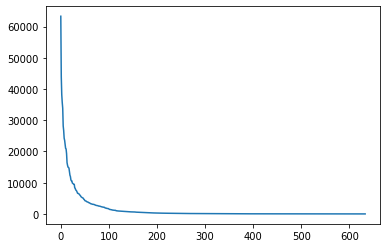

In [129]:
genres_count.sort_values(ascending=False).reset_index(drop=True).plot();

In [130]:
unique_item_tags = genres_count.sort_values(ascending=False)[:200].index
unique_item_tags[:10]

Index(['любовное фэнтези', 'попаданцы', 'современные любовные романы',
       'современные детективы', 'героическое фэнтези', 'боевая фантастика',
       'зарубежные любовные романы', 'боевое фэнтези',
       'современная русская литература', 'книги про волшебников'],
      dtype='object', name='genres')

In [131]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [132]:
%%time
i_features_lfm['features'] = i_features_lfm['genres'].apply(filter_genres, valid_genres=set(unique_item_tags))

CPU times: user 137 ms, sys: 1.6 ms, total: 138 ms
Wall time: 136 ms


In [133]:
i_features_list = i_features_lfm['features']
i_features_list[:5]

item_id
23831    [зарубежные детские книги, сказки, зарубежная ...
39149    [классическая проза, литература 19 века, русск...
17678    [зарубежная классика, классическая проза, лите...
46007            [пьесы и драматургия, литература 19 века]
54532    [зарубежная классика, классическая проза, лите...
Name: features, dtype: object

#### LightFM Dataset
Посмотрим на то, как в каком формате принимает данные lightfm и как использовать Dataset для конвертации.

LightFM работает со sparse-матрицами, dataset конвертирует данные в coo-формат.
Матрица взаимодействий — это просто матрица размером количество пользователей $\times$ количество объектов.
Матрицы признаков выглядят интереснее.

In [134]:
lfm_dataset = LFMDataset()

In [135]:
lfm_dataset.fit_partial(users=filtered_df['user_id'].unique(), items=filtered_df['item_id'].unique())
lfm_dataset.fit_partial(user_features=unique_user_tags, item_features=unique_item_tags)

In [136]:
unique_user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

In [137]:
user_mapping, item_mapping = lfm_dataset.mapping()[0], lfm_dataset.mapping()[2]

In [138]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

#### transform features

In [139]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [140]:
sparse_i_features.shape

(56752, 56952)

In [141]:
sparse_i_features[0, :].nonzero(), sparse_i_features[0, :].data

((array([0, 0, 0, 0], dtype=int32),
  array([    0, 56761, 56767, 56789], dtype=int32)),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32))

#### transform log

In [142]:
%%time
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in train_by_date.itertuples()])

CPU times: user 1.54 s, sys: 20.5 ms, total: 1.56 s
Wall time: 1.56 s


Посмотрим на содержание матриц interactions и weights: использую матрицу interactions можно легко перейти от explicit feedback к implicit. Будем использовать weights, можете поэкспериментировать с interactions самостоятельно.

In [143]:
interactions.shape, interactions.data

((37004, 56752), array([1, 1, 1, ..., 1, 1, 1], dtype=int32))

Посмотрим на применение модели и воспроизведем подсчет релевантности.

### model training

In [144]:
%%time
lightfm = LightFM(no_components=64, loss='warp', random_state=SEED)
lightfm.fit(interactions, user_features=sparse_u_features, item_features=sparse_i_features, epochs=40, num_threads=8)

CPU times: user 1min 54s, sys: 27.3 ms, total: 1min 54s
Wall time: 29.7 s


### predict для одного пользователя

Посмотрим рекомендации для любителя боевой фантастики

In [145]:
pred = lightfm.predict(user_ids=user_mapping[21], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)

In [146]:
ids = np.argpartition(pred, -K)[-K:]
rel = pred[ids]
res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
res['item_id'] = res['item_id'].map(inv_item_mapping)

In [147]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
5,50385,-116.191528,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018,307
8,39338,-116.916901,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011,43
4,34563,-116.985504,Ночной Дозор,"Боевое фэнтези,Городское фэнтези",Сергей Лукьяненко,1998,51
7,57154,-116.985542,Игра престолов. Часть I,"Зарубежное фэнтези,Боевое фэнтези",Джордж Мартин,1996,151
6,44529,-116.995384,Ведьма-хранительница,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003,85
9,22157,-117.078331,Верховная Ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2004,81
3,51257,-117.110458,Профессия: ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003,92
2,5950,-117.135597,Игра престолов,"Героическое фэнтези,Зарубежное фэнтези,Боевое ...",Джордж Мартин,1996,90
1,41418,-117.168228,Академия темных. Преферанс со Смертью,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Лика Верх,2017,37
0,38005,-117.180389,Антимаг,"Боевое фэнтези,Книги про волшебников",Наталья Жильцова,2015,67


Посмотрите на рекомендации, все ли ок? Есть ли какие-то "лишние" книги?

## 7.1 Задание (0.25 балла): посчитайте релевантность руками
Посчитайте релевантность книги "Магический спецкурс. Второй семестр" (43272) для пользователя 100017, который читает всякое такое.
Используйте методы get_item_representations(), get_user_representations(), которые есть у модели LightFM.

In [148]:
i_features.loc[43272]

title                    Магический спецкурс. Второй семестр
genres     Любовно-фантастические романы,Попаданцы,Любовн...
authors                                          Лена Летняя
year                                                    2018
Name: 43272, dtype: object

In [149]:
item_id_lfm = item_mapping[43272]
user_id_lfm = user_mapping[21]

In [150]:
rel = lightfm.predict(user_ids=user_id_lfm, 
                      item_ids=[item_id_lfm], 
                      user_features=sparse_u_features, 
                      item_features=sparse_i_features)[0]
rel

-118.820366

Получили релевантность моделью, проверим, что поняли, как оно работает

Отлично, разобрались с тем, как использовать модели LightFM, давайте попробуем воспроизвести подсчет релевантности. Для этого вернемся к формуле:

$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков
$b_u, b_i$ - смещения для признаков пользователя и объекта


In [151]:
u_biases, u_vectors = lightfm.get_user_representations()
u_vectors.shape, u_biases.shape

((37012, 64), (37012,))

In [152]:
i_biases, i_vectors =lightfm.get_item_representations()
i_vectors.shape, i_biases.shape

((56952, 64), (56952,))

In [153]:
suf = sparse_u_features[user_id_lfm]
sif = sparse_i_features[item_id_lfm]
uv = suf @ u_vectors
iv = sif @ i_vectors

rel_ours = (uv @ iv.T + suf * u_biases + sif * i_biases)[0][0]
rel_ours

-118.820335

In [154]:
assert math.isclose(rel, rel_ours, rel_tol=1e-5)

Все совпало, мы молодцы! Имея вектора пользователей и объектов, мы можем искать похожих, как делали это в ALS.

## 7.2 Задание (0.25 балла): допишите predict, чтобы заработало 
(авторское решение использует apply для каждого пользователя)

In [163]:
from typing import Dict, Iterable
class UserFriendlyLightFM(SVDModel):
    user_mapping: Dict
    item_mapping: Dict
    inv_user_mapping: Dict
    inv_item_mapping: Dict
    lightfm_dataset: LFMDataset
        
    def __init__(self, 
                 user_ids: np.ndarray, 
                 item_ids: np.ndarray,
                 user_tags: Optional[Iterable],
                 item_tags: Optional[Iterable],
                 epochs: int,
                 model: LightFM
                ):
        self.lightfm_dataset = LFMDataset()
        self.lightfm_dataset.fit(users=user_ids, 
                                         items=item_ids,
                                         user_features=user_tags,
                                         item_features=item_tags,
                                        )
        self.user_mapping = self.lightfm_dataset.mapping()[0]
        self.item_mapping = self.lightfm_dataset.mapping()[2]
        self.inv_user_mapping = {value: key for key, value in self.user_mapping.items()}
        self.inv_item_mapping = {value: key for key, value in self.item_mapping.items()}
        self.epochs = epochs
        self.model = model

        
    def _transform_dataset(self, 
                           log: Optional[pd.DataFrame],
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        
        (interactions, weights) = self.lightfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in log.itertuples()]) if log is not None else (None, None)
        user_features_sparse = self.lightfm_dataset.build_user_features([[row.user_id, row.features] for row in user_features.reset_index().itertuples()]) if user_features is not None else None
        item_features_sparse = self.lightfm_dataset.build_item_features([[row.item_id, row.features] for row in item_features.reset_index().itertuples()]) if item_features is not None else None
        return interactions, weights, user_features_sparse, item_features_sparse
    
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'UserFriendlyLightFM':
        
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(log, user_features, item_features)
        self.model.fit(interactions, user_features=user_features_sparse, item_features=item_features_sparse, epochs=self.epochs, num_threads=8)
        return self

    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        pred = pd.DataFrame(users.map(self.user_mapping).unique(), columns=['user_id'])
        pred.dropna(inplace=True)
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(None, user_features, item_features)
        
        def _get_lfm_pred_all_items(user_id):
            pred_all = self.model.predict(user_ids=user_id, item_ids=sorted(self.item_mapping.values()), user_features=user_features_sparse, item_features=item_features_sparse)
            # ids = pd.Series(pred_all).sort_values(ascending=False)[:k].index
            
            ids = np.argpartition(pred_all, -k)[-k:] 
            # если я правильно понял, argpartition перекидывает все самые большие значения правее заданнй позиции
            # поэтому такое будет работать
            
            rel = pred_all[ids]
            return list(zip(ids, rel))
    
        pred['recs'] = pred['user_id'].apply(_get_lfm_pred_all_items)
        pred = pred.explode('recs')
        self._split_pair(pred)
        pred['item_id'] = pred['item_id'].map(self.inv_item_mapping)
        pred['user_id'] = pred['user_id'].map(self.inv_user_mapping)
        return pred

## LightFM без признаков

In [156]:
lfm = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(), 
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=40,
                             model=LightFM(no_components=64, loss='warp'))

In [157]:
 %%time
lfm.fit(log=train_by_date, user_features=None, item_features=None)

CPU times: user 1min 9s, sys: 123 ms, total: 1min 10s
Wall time: 19.9 s


In [158]:
%%time
lfm_pred = lfm.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=None, item_features=None)

CPU times: user 1min, sys: 264 ms, total: 1min
Wall time: 1min


In [159]:
%%time
measure(lfm_pred, test_by_date, 'LightFM_rec_64_40_ep', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

CPU times: user 790 ms, sys: 33.9 ms, total: 824 ms
Wall time: 850 ms


,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
LightFM_rec_64_40_ep,0.014773,0.09849,0.033801,0.010653,0.097424,0.592238
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.531623
svd_rec,0.020026,0.070584,0.034071,0.010541,0.018149,0.429524
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.429753


## LightFM  c признаками

In [160]:
lfm_uf = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(), 
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=40,
                             model=LightFM(no_components=256, loss='warp')
                            )

In [161]:
%%time
lfm_uf.fit(log=train_by_date, item_features=i_features_list, user_features=u_features_list)

CPU times: user 5min 53s, sys: 252 ms, total: 5min 53s
Wall time: 1min 32s


In [162]:
%%time
pred_feat = lfm_uf.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=u_features_list, item_features=i_features_list)

CPU times: user 4min 26s, sys: 423 ms, total: 4min 27s
Wall time: 4min 27s


In [164]:
%%time
measure(pred_feat, test_by_date, 'LightFM_rec_features_256_40', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

CPU times: user 745 ms, sys: 30.8 ms, total: 776 ms
Wall time: 786 ms


,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
LightFM_rec_64_40_ep,0.014773,0.09849,0.033801,0.010653,0.097424,0.592238
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.531623
svd_rec,0.020026,0.070584,0.034071,0.010541,0.018149,0.429524
LightFM_rec_features_256_40,0.008864,0.06172,0.021587,0.004115,0.123185,0.62498
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.429753


## **Задание 7.3 (0.5 балла)** Сделайте выводы о полученных значениях метрик. Как повлияло на метрики  добавление признаков?

#MY ANSWER HERE

*Добавление признаков сказалось не очень хорошо на hit_rate, mrr, map. Предположу, что это из-за того, что мы скормили недостаточно данных. Но зато в этом случае самый высокий coverage и surprisal.*

Итак, теперь у нас есть следующие модели:

- рекомендатель популярного
- knn на ассоциативных правилах
- svd
- lightFM
    
Но почему бы не решать задачу рекомендаций как задачу ранжирования или классификации с использованием популярных алгоритмов машинного обучения? В таком случае мы будем по вектору признаков пользователя и объекта предсказывать значение релевантности.
Вот некоторые причины:

- данных очень много, и на инференсе скорить все возможные пары пользователь-объект — очень долго
- чаще всего у нас нет класса 0 или этих данных мало, а значит, их нужно сэмплировать
- кажется, что модели будет сложно обобщить коллаборативную информацию, т.е. использовать информацию о предыдущих взаимодействиях, потому что на вход подается только одно взаимодействие

Как с этим бороться? 

- Использовать многоуровневые модели (например, ALS + градиентный бустинг/нейросеть)
    

# 8 Двухуровневая модель

- Как разбить данные без лика?
- Сколько кандидатов генерировать и как?
- Какие признаки добавить для обучения модели второго уровня?
- Как переобучать весь ансамбль?

Примеры:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224/)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Дзен-митап: Объяснимые рекомендации](https://www.youtube.com/watch?v=ll-y6I_r_OM&t=357s)
- [Дзен-митап: Next-level recommendations — как сделать модель второго уровня в рекомендациях](https://www.youtube.com/watch?v=4NutBpiIHi0&t=1240s)
    
    

Команда MTS выложила лекцию про двухуровневую архитектуру — довольно понятно, быстро объясняется и с кодом.
Посмотрите [видео](https://ods.ai/tracks/recsys-course2021/blocks/34e6b8d3-5cf0-4ab8-9443-fbc14ad9cf0b) и [код](https://github.com/sharthZ23/your-second-recsys/tree/master/lecture_5).

Например, обучим SVD на 70% train, а вторым уровнем выберем Catboost, добавив в качестве признаков название, год выпуска книги и автора 

In [165]:
! pip install --upgrade catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached catboost-1.0.5-cp38-none-manylinux1_x86_64.whl (76.6 MB)
  Attempting uninstall: catboost
    Found existing installation: catboost 1.0.4
    Uninstalling catboost-1.0.4:
      Successfully uninstalled catboost-1.0.4


### Разобьем данные

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
Q = 0.7
train_first = train_by_date[train_by_date['start_date'] <= train_by_date['start_date'].quantile(Q)].copy()
train_second = train_by_date[train_by_date['start_date'] > train_by_date['start_date'].quantile(Q)].copy()
# убрали холодных для быстроты расчета, а не потому, что так надо
train_second = train_second[train_second['user_id'].isin(train_first['user_id'].unique())]
train_u_second, val_u_second = train_test_split(train_second['user_id'].unique(), test_size=0.1, random_state=SEED)

In [168]:
get_df_info(train_first)

Размер данных = 250664,
количество пользователей = 36083,
количество объектов = 51725


In [169]:
get_df_info(train_second)

Размер данных = 101765,
количество пользователей = 24785,
количество объектов = 32282


## **8.1 Задание (0.25 балла)**: Обучите SVD на данных train first и получите predict топ-50 объектов для пользователей из train_second

In [170]:
%%time
first_level = SVDModel(rank=64)

first_level.fit(train_first)
first_level_pred = first_level.predict(train_first, pd.Series(train_second['user_id'].unique()), k=50) 

CPU times: user 10min 24s, sys: 3min 25s, total: 13min 50s
Wall time: 3min 28s


Здесь самое время подумать, какие еще модели/бейзлайны можно использовать для генерации кандидатов, отдельно подумать над кандидатами для холодных пользователей.


## 8.2 Добавим столбец target_cb, содержащий метку класса

In [171]:
train_second['target_cb'] = 1

In [172]:
first_level_pred = first_level_pred.merge(train_second[['user_id', 'item_id', 'target_cb']], on=['user_id', 'item_id'], how='left')
first_level_pred.fillna(0, inplace=True)

In [173]:
first_level_pred.head(2)

,user_id,item_id,relevance,target_cb
0,31251,20424,0.126334,0.0
1,31251,29087,0.123439,0.0


In [174]:
assert first_level_pred['target_cb'].sum() > 0

In [175]:
first_level_pred.groupby('target_cb').count()

,user_id,item_id,relevance
target_cb,,,
0.0,227967,227967,227967
1.0,1173,1173,1173


## Добавим признаки

In [176]:
i_features['year_conv'] = i_features.loc[:, 'year'].str.extract(r'(\d{4})', expand=False).astype(float)

In [177]:
CAT_COLS = [1, 2, 3]

def preprocess_cb(pd_df):
    full_feat = pd_df.merge(u_features, left_on='user_id', right_index=True, how='left')
    full_feat = full_feat.merge(i_features[['authors', 'year_conv']], left_on='item_id', right_index=True, how='left')
    target = full_feat['target_cb']
    full_feat['rank'] = full_feat.groupby('user_id')['relevance'].rank(method="first", ascending=False)
    ids = full_feat[['user_id', 'item_id']]
    cb_train = full_feat.drop(columns=['user_id', 'item_id', 'target_cb'])
    cb_train['sex'] = cb_train['sex'].astype('str')
    cb_train.iloc[:, CAT_COLS] = cb_train.iloc[:, CAT_COLS].fillna('nan')
    return cb_train, target, ids

In [178]:
cb_train, target, ids = preprocess_cb(first_level_pred)

In [179]:
cb_train.head(2)

,relevance,age,sex,authors,year_conv,rank
0,0.126334,55_64,0.0,Елена Звёздная,2015.0,1.0
1,0.123439,55_64,0.0,Елена Звёздная,2015.0,2.0


## Обучим Catboost

In [180]:
from catboost import CatBoostClassifier

In [181]:
catcls = CatBoostClassifier(iterations=30)

In [182]:
%%time
cb_fitted = catcls.fit(cb_train[first_level_pred['user_id'].isin(train_u_second)], 
                       target[first_level_pred['user_id'].isin(train_u_second)], 
                       eval_set=(cb_train[~first_level_pred['user_id'].isin(train_u_second)], 
                       target[~first_level_pred['user_id'].isin(train_u_second)]),
                       cat_features=[1, 2, 3], 
                       early_stopping_rounds=10)

Learning rate set to 0.5
0:	learn: 0.3214529	test: 0.3214138	best: 0.3214138 (0)	total: 90ms	remaining: 2.61s
1:	learn: 0.1824509	test: 0.1823943	best: 0.1823943 (1)	total: 123ms	remaining: 1.72s
2:	learn: 0.1126688	test: 0.1126402	best: 0.1126402 (2)	total: 155ms	remaining: 1.4s
3:	learn: 0.0747705	test: 0.0747279	best: 0.0747279 (3)	total: 197ms	remaining: 1.28s
4:	learn: 0.0534115	test: 0.0533504	best: 0.0533504 (4)	total: 224ms	remaining: 1.12s
5:	learn: 0.0413263	test: 0.0413022	best: 0.0413022 (5)	total: 247ms	remaining: 987ms
6:	learn: 0.0345308	test: 0.0345067	best: 0.0345067 (6)	total: 265ms	remaining: 872ms
7:	learn: 0.0305714	test: 0.0305452	best: 0.0305452 (7)	total: 290ms	remaining: 799ms
8:	learn: 0.0282788	test: 0.0283332	best: 0.0283332 (8)	total: 309ms	remaining: 720ms
9:	learn: 0.0270012	test: 0.0271084	best: 0.0271084 (9)	total: 333ms	remaining: 667ms
10:	learn: 0.0263673	test: 0.0266687	best: 0.0266687 (10)	total: 361ms	remaining: 624ms
11:	learn: 0.0259353	test: 0.

In [183]:
imp = list(zip(catcls.feature_names_, catcls.feature_importances_))
imp.sort(key=lambda x: -x[1])
imp

[('relevance', 68.20226209726816),
 ('authors', 10.348133695851198),
 ('year_conv', 6.707197967027495),
 ('age', 6.42751652296837),
 ('sex', 6.22026777429872),
 ('rank', 2.0946219425860444)]

### Получим predict

In [184]:
first_level_pred_for_test = first_level.predict(log=train_by_date[train_by_date['user_id'].isin(test_by_date_users.values)], users=pd.Series([21], name='user_id'), k=100)
first_level_pred_for_test['target_cb'] = 0
cb_for_test, target_for_test, ids_for_test = preprocess_cb(first_level_pred_for_test)

In [185]:
cb_pred = catcls.predict_proba(cb_for_test)
ids_for_test['relevance'] = cb_pred[:, 1]
res = filter_seen_items(train_by_date, ids_for_test)
res = leave_top_k(res, k=K)

In [186]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,user_id,item_id,relevance,title,genres,authors,year,popularity
6,21,21461,0.003570,Самоволка,"Боевая фантастика,Попаданцы","Сергей Лукьяненко,Михаил Тырин",2014,73
9,21,28373,0.002693,Дозоры. От Ночного до Шестого (сборник),"Героическое фэнтези,Городское фэнтези","Владимир Васильев,Сергей Лукьяненко",NaN,70
1,21,56368,0.002384,Новый Дозор,"Боевое фэнтези,Городское фэнтези",Сергей Лукьяненко,2012,114
0,21,27304,0.002078,Шестой Дозор,"Городское фэнтези,Книги про вампиров",Сергей Лукьяненко,2014,161
3,21,50905,0.002048,Чистовик,Научная фантастика,Сергей Лукьяненко,2007,390
4,21,10247,0.001849,Холодные берега,Историческая фантастика,Сергей Лукьяненко,1998,45
5,21,26225,0.001849,Геном,"Космическая фантастика,Научная фантастика",Сергей Лукьяненко,1999,49
2,21,13068,0.001767,Танцы на снегу,"Космическая фантастика,Научная фантастика",Сергей Лукьяненко,1999-2001,46
7,21,25343,0.001639,Последний Дозор,Городское фэнтези,Сергей Лукьяненко,2005,54
8,21,57410,0.001300,КВАЗИ,"Социальная фантастика,Детективная фантастика",Сергей Лукьяненко,2016,39


### **Задание 8.3 (0.25 балла)**: сделайте выводы о полученных рекомендациях

Чтобы двухуровневая модель стала работать лучше коллаборативных моделей, обученных на полных данных, нужно:
- чтобы данных было достаточно
- подобрать модели первого уровня, дающие хороший recall (много релевантных кандидатов) как для холодных, так и для теплых пользователей
- подумать над задачей и областью и сгенерировать дополнительные признаки. Почитать о том, какие признаки можно генерировать для обучения двухуровневой модели на задачу рекомендаций можно в статьях с решениями конкурсов из раздела про LightFM.

Примеры признаков для MTS библиотеки:
- как давно последний раз читали эту книгу
- доля книг этого автора от общего числа прочтенных
- популярность книги всего/за последнюю неделю/месяц
- вектора пользователей и айтемов из модели 1 уровня
- падает или растет популярность книги за последнее время

Возможность сгенерировать признаки и использовать на первом уровне не одну модель, а несколько, еще ждет вас в лабе/конкурсе.

# 9 Нейросети

Практически любые нейросетевые архитектуры можно перенести в рекомендации

![nlp_recsys](https://miro.medium.com/max/1400/0*BYMSTEtMuf8Blk34)

[source](https://nvidia-merlin.github.io/Transformers4Rec/main/why_transformers4rec.html)

- Нейроколлаборативная матричная факторизация
- Embeddings + MLP/кастомные слои на признаках, обучающиеся на вероятность клика/релевантность: DSSM, DLRM, Wide&Deep, DeepFM, Deep&Cross)
- сверточные: Caser
- рекуррентные: GRU4Rec, 
- трансформеры: Bert4Rec, Transformers4Rec
- автоэнкодеры: MultVAE, RecVAE

## MultVAE

Почему MultVAE? 
- Авторы MultVAE в своей [статье](https://arxiv.org/pdf/1802.05814.pdf) 2018 года писали, что MultVAE дает хорошее качество рекомендаций по сравнению с классическими методами. В статье 2019 года [Are We Really Making Much Progress? A Worrying Analysis of Recent Neural Recommendation Approaches](https://arxiv.org/pdf/1907.06902.pdf) о воспроизводимости результатов это было подтверждено. Предлагаю им поверить)
- Выглядит элегантно + с ним часто сравниваются в статьях!

![multvae](https://sberbank-ai-lab.github.io/RePlay/_images/vae-gaussian.png)

Подаем на вход:
- Историю пользователя (вектор из 0 и единиц)

Хотим получить:
- Восстановленный x, содержащий релевантности для объектов, с которыми не было взаимодействий (берем Softmax от выходов decoder-а)

In [187]:
! pip install torch
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [229]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

### Подготовка данных

In [230]:
class MultVAEDataset(Dataset):
    def __init__(self, X, item_count):
        self.item_count = item_count
        # introduce new user ids to reduce sparse matrix size
        self.user_mapping = {u_id: i for i, u_id in enumerate(X["user_id"].unique())}
        self.inverse_users_mapping ={i: u_id for u_id, i in self.user_mapping.items()}
        self.X = csr_matrix((
                np.ones(len(X["user_id"])),
                (X["user_id"].map(self.user_mapping).values, X["item_id"].values)),
                shape=(len(self.user_mapping), self.item_count))
        
        
    def __len__(self):
        return len(self.user_mapping)

    def get_vector(self, u_id):
        return self.X[self.user_mapping[u_id]].toarray().ravel().astype('float32')

    def __getitem__(self, idx):
        return self.X[idx].toarray().ravel().astype('float32'), self.inverse_users_mapping[idx]

In [231]:
train_u_mult, val_u_mult = train_test_split(train_by_date['user_id'].unique(), test_size=0.2, random_state=SEED)
X_train = train_by_date[train_by_date['user_id'].isin(train_u_mult)]
X_val = train_by_date[train_by_date['user_id'].isin(val_u_mult)]

In [232]:
vector_len = train_by_date['item_id'].max() + 1
train_dataset = MultVAEDataset(X_train, vector_len)
val_dataset = MultVAEDataset(X_val, vector_len)

In [233]:
batch_size = 1024
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [234]:
%%time
test_b = next(iter(train_dl))
assert test_b[0].size() == (batch_size, vector_len)

CPU times: user 611 ms, sys: 206 ms, total: 817 ms
Wall time: 445 ms


### Архитектура сетки

**Задание 9.1 (0.5 балла)**: 
Если вы еще живы, набросайте свою архитектуру согласно картинке и статье. Можно использовать такие размерности линейных слоев:

энкодер: I(число item-ов)→600→200*2

декодер: 200→600→I.

Получив из энкодера вектор длины 200*2, используйте первые 200 значений как $\mu$ многомерного распределения, а оставшиеся как $log(variance)$.
Обратите внимание, что мы сэмплируем латентное представление во время обучения, а для inference используем только значения $\mu$.

Выделите encoder/decoder как отдельные атрибуты модели. 

In [241]:
class MultVAE(nn.Module):
    def __init__(self, input_size, latent_size, drop=0.2):
        self.latent = latent_size
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(drop), 
            nn.Linear(input_size, 3 * latent_size), 
            nn.ReLU(), 
            nn.Linear(3 * latent_size, 2 * latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 3 * latent_size), 
            nn.ReLU(), 
            nn.Linear(3 * latent_size, input_size)
        )
        
    def encode(self, batch):
        x = F.normalize(batch, dim=1)
        mu_logvar = self.encoder(x)
        mu = mu_logvar[:, : self.latent]
        logvar = mu_logvar[:, self.latent :]
        return mu, logvar


    def decode(self, batch):
        return self.decoder(batch)


    def forward(self, batch):
        mu, logvar = mu, logvar = self.encode(batch)
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            latent = mu + std * eps
        else:
            latent = mu
        output = self.decode(latent)
        return output, mu, logvar

### loss

![multvae](https://sberbank-ai-lab.github.io/RePlay/_images/vae-gaussian.png)

В модели используется evidence lower bound(ELBO) loss function с гиперпараметром $\beta$, позволяющем настраивать степень регуляризации (влияния KL-дивергенции). Почему loss такой и как это связано с максимизацией правдоподобия, можно почитать [тут](https://colab.research.google.com/github/jrzaurin/infinitoml/blob/master/_notebooks/2020-05-15-mult-vae.ipynb).


ELBO: 

$$
\mathcal L(\mathbf{\text{X}}^M, \phi,\theta) \simeq \frac{1}{M} \sum_{u=1}^{M} - D_{KL}\left(q_\phi(\textbf{z}_u\vert \textbf{x}_u) \| p_\theta(\textbf{z}_u) \right) + \log  p_{\theta}(\mathbf{x}_u \vert \mathbf{z}_u)
$$


Распределение для $z_u$ - стандартное нормальное.
$$p(\textbf{z}_u) \sim \mathcal N(0, I)$$

Пусть мы получаем на выходе сети $\pi(\mathbf{z}_u)$:
$$\pi(\mathbf{z}_u) = Softmax(MLP(\mathbf{z}_u))$$

и $x_u$ имеет мультиномиальное распределение, где $N_u$ - общее число item-ов, оцененное пользователем, $\pi(\mathbf{z}_u)$ - вектор вероятностей выбора item-ов:
$$
\textbf{x}_u \sim \text{Mult}(N_u, \pi(\mathbf{z}_u))
$$

Первый компонент функции потерь представим в виде:
$$
\begin{equation*}
\log(p_{\theta}(\textbf{x}_u\vert \textbf{z}_u)) = \mathbf{x}_u \log(\pi(\mathbf{z}_u))
\end{equation*}
$$


Второй - KL-дивергенция для двух нормальных распределений, одно из которых стандартное:
$$KL(q_\phi(z | x) || p(z)) = -\frac{1}{2}\sum_{j=1}^{dimZ}(1+
log(\sigma_j^2) - \mu_j^2-\sigma_j^2)$$


Получим такую функцию потерь, которую и предлагается закодить:
$$
Loss = -\frac{1}{M} \sum_{u=1}^{M} \left[ \mathbf{x}_u \log(\pi(\mathbf{z}_u)) + \frac{\beta}{2}  \sum_{j=1}^{dimZ}( 1 + \log(\sigma_{uj}^2) - \mu_{uj}^2 - \sigma_{uj}^2 )  \right]
$$




Более развернуто и строго о loss для MultVAE можно почитать в [статье](https://arxiv.org/pdf/1802.05814.pdf), [в подробном туториале](https://colab.research.google.com/github/jrzaurin/infinitoml/blob/master/_notebooks/2020-05-15-mult-vae.ipynb) и [документации к одной из реализаций](https://sberbank-ai-lab.github.io/RePlay/pages/modules/models.html#mult-vae).

**Задание 9.2 (0.25 балла)**: реализуйте функцию вычисления loss

In [242]:
 def mult_vae_loss(y_pred, y_true, mu, logvar, anneal):
    neg_log_loss = -1 * (F.log_softmax(y_pred, dim=1) * y_true).sum(dim=1).mean()
    kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
    return neg_log_loss + anneal * kld

### Обучение/валидация

In [243]:
from tqdm.notebook import tqdm
ANNEAL = 0.2

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for batch, ids in tqdm(loader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out, mu, logvar = model(batch)
        loss = criterion(out, batch, mu, logvar, ANNEAL)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for batch, ids in tqdm(loader):
            batch = batch.to(device)
            
            out, mu, logvar = model(batch)
            loss = criterion(out, batch, mu, logvar, ANNEAL)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

### Цикл обучения

In [244]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            # plt.yscale('log')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

In [245]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = MultVAE(vector_len, 300)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

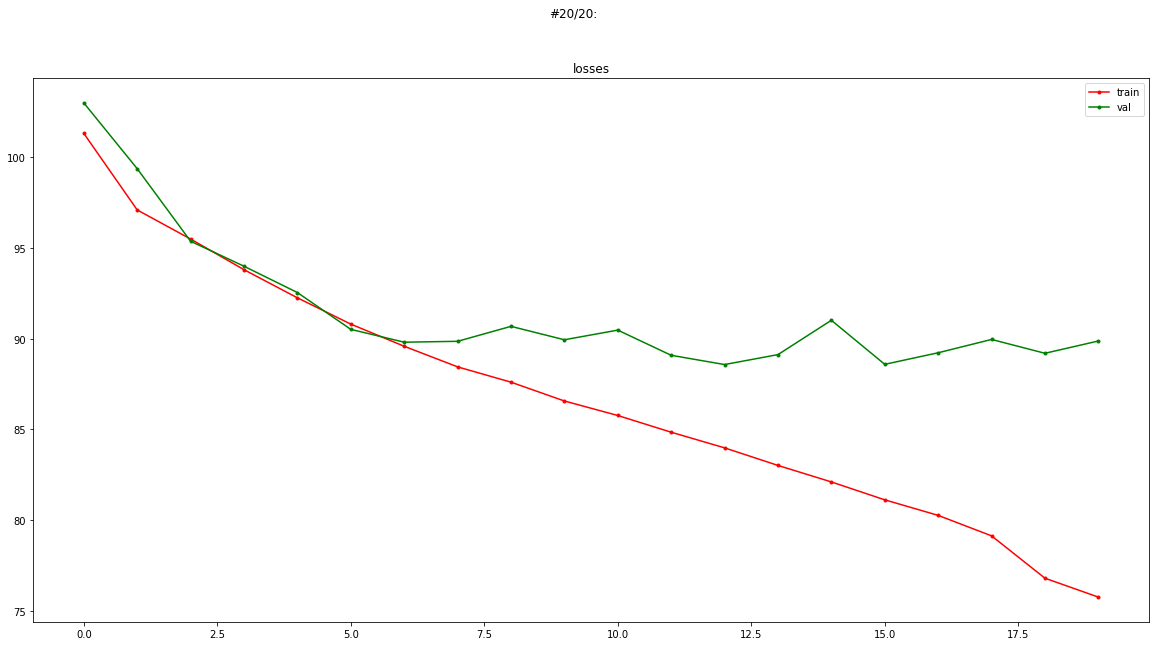

In [246]:
model, optimizer, losses = learning_loop(model=model, 
              optimizer=optimizer, 
              train_loader=train_dl, 
              val_loader=valid_dl, 
              criterion=mult_vae_loss, 
              scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True), 
              min_lr=1e-6, 
              epochs=20, 
              val_every=1, 
              draw_every=1, 
              separate_show=False)






Это упрощенная реализация модели, для улучшения результата можно заняться, например, подбором параметров или настройкой anneal по расписанию.

In [247]:
seen = train_by_date[train_by_date['user_id'] == 21].shape[0]
output= model(torch.tensor(train_dataset.get_vector(21)).reshape(1, -1).to(device))[0].detach().cpu().numpy().flatten()
ids = np.argpartition(output, -(seen + K))[-(seen + K):]
rel = output[ids]
res = pd.DataFrame({'item_id' : ids, 'relevance': rel})
res['user_id'] = 21
pred_21 = filter_seen_items(X_train, res)
pred_21 = leave_top_k(pred_21, K)

In [248]:
pred_21.merge(i_features, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,user_id,title,genres,authors,year,year_conv
7,19477,3.918361,21,Заклинатели,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2011,2011.0
9,31099,3.344485,21,Ловцы удачи,Боевое фэнтези,Алексей Пехов,2012,2012.0
8,12691,3.319438,21,Ловушка для духа,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2016,2016.0
6,13898,3.297379,21,Пожиратель душ,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2005,2005.0
2,1036,3.289692,21,Искатели ветра,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2005,2005.0
0,30917,3.220218,21,Знаки ночи,"Городское фэнтези,Книги про волшебников",Андрей Васильев,2018,2018.0
3,52265,3.187331,21,Жнецы ветра,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2008,2008.0
1,32832,3.139182,21,Пересмешник,"Детективное фэнтези,Городское фэнтези,Книги пр...",Алексей Пехов,2009,2009.0
4,10074,3.004231,21,Ветер и искры (сборник),"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2005-2008,2005.0
5,41344,2.936727,21,Ветер полыни,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2006,2006.0


**Задание 9.3 (0.25 балла)**: сделайте выводы о полученных рекомендациях

#MY ANSWER HERE

*Посмотрим на историю прочтений (ниже) пользователя 21. Полученные рекомендации похожи на историю прочтений как жанрами, так и авторами.*

*Спасибо за семинар, за эти дни я познакомился с задачами и методами и очень прокачался в pandas*

In [255]:
train_by_date[train_by_date['user_id'] == 21].merge(i_features, on='item_id')

,user_id,item_id,progress,rating,start_date,title,genres,authors,year,year_conv
0,21,4375,54,NaN,2018-05-01,Выстрел в сердце,Современная русская литература,Герман Садулаев,2017,2017.0
1,21,5909,85,5.0,2018-05-22,Спектр,"Социальная фантастика,Космическая фантастика,Н...",Сергей Лукьяненко,2001-02,2001.0
2,21,42197,100,NaN,2018-12-05,История Бледной Моли,"Героическое фэнтези,Любовное фэнтези",Настя Любимка,2017,2017.0
3,21,13438,100,NaN,2019-03-30,Честь Белого Волка,Юмористическое фэнтези,Андрей Белянин,2018,2018.0
4,21,28402,100,NaN,2019-04-15,Свирепый ландграф,Юмористическое фэнтези,Андрей Белянин,1998,1998.0
5,21,5795,99,NaN,2019-05-28,Век святого Скиминока,"Героическое фэнтези,Юмористическое фэнтези",Андрей Белянин,1998,1998.0
6,21,13389,100,NaN,2019-07-23,Страж,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2010,2010.0
7,21,39338,99,NaN,2019-07-24,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011,2011.0
8,21,22637,100,5.0,2019-07-29,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012,2012.0
9,21,7211,96,NaN,2019-08-01,Проклятый горн,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014,2014.0


**UPD от 5.04.2022:** Почему нет метрик? 

Для MultVAE и двухуровневой модели мы уже не считали метрики для тестовой выборки, потому что в этих блоках семинара поменялась задача — хотелось посмотреть на архитектуру и логику реализации отдельных частей кода, а не запустить "из коробки" библиотечную модель, примерно поняв, как она работает.

Чтобы посчитать метрики MultVAE на нашем датасете можно:
- Настроить расписание lr и сохранение лучшей модели в цикле обучения
- Возможное улучшение: Дополнительно отслеживать не только loss на валидации (т.к. он слабо связан с задачей рекомендаций), но и метрику качества (NDCG/MAP), чтобы выбрать лучшую модель
- Дописать predict моделью на группу пользователей по аналогии с предыдущими моделями, обернутыми в класс.

Или попробовать запустить одну из готовых реализаций, например, из [RecBole](https://recbole.io/docs/user_guide/model/general/multivae.html) или [RePlay](https://sberbank-ai-lab.github.io/RePlay/pages/modules/models.html#mult-vae).

# Выводы
- мы поговорили про особенности задачи, метрики и разнообразные требования к рекомендательным системам
- получили примеры кода для моделей и подсчета метрик, которые могут быть полезны в лабе и конкурсе
- попробовали SVD, LightFM
- поговорили немного про двухуровневые архитектуры
- поняли, что рекомендательные системы — это не только матричная факторизация. Можно учить нейронки, хотя до сих пор в конкурсах часто побеждает бустинг со сложной генерацией признаков.
- все архитектуры рекомендательных систем уже реализовали и выложили на github до нас, и надо просто найти нужную библиотеку. Например: [NVIDIA-Merlin](https://github.com/NVIDIA-Merlin/Merlin), [MS recommenders](https://github.com/microsoft/recommenders), [RecBole](https://github.com/RUCAIBox/RecBole), [Elliot](https://github.com/sisinflab/elliot), [RePlay](https://github.com/sberbank-ai-lab/RePlay).

*[Репозиторий](https://github.com/monkey0head/recsys_sem)*

Делайте pull request-ы, чтобы сделать этот ноутбук лучше

*Автор:* 
@monkey_head

Напишите автору, если в этом семинаре очень нужно что-нибудь исправить